TODO

* READ API DOCS:


1.   Anthropic https://docs.anthropic.com/en/docs/build-with-claude/vision
2.   Google https://docs.anthropic.com/en/docs/build-with-claude/vision
3.   Replicate https://docs.anthropic.com/en/docs/build-with-claude/vision

* IDEAS TO IMPLEMENT:

0.   Engineer the geoguessr player prompt
1.   Set output format for all models
2.   Returning directions to look at + querying streetview API
3.   Returning bounding box to zoom in, option to zoom out and look at another thing
4.   Future work: Videos, audio
5. Fix code to handle errors without crashing the block





In [ ]:
!pip install replicate openai anthropic --quiet
!pip install -q -U google-generativeai
import math
import csv
import os
import base64
import requests
import json
from datetime import datetime
import time
import re
import anthropic
import pandas as pd
import openai
import replicate
import anthropic
import google.generativeai as genai
from IPython.display import Markdown
import PIL.Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 5.9 MB/s eta 0:00:00


In [ ]:
from google.colab import auth
auth.authenticate_user()


In [ ]:
#@title Setting keys
import os
from google.colab import userdata
#os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
# os.environ['ANTHROPIC_API_KEY'] = userdata.get('ANTHROPIC_API_KEY')
os.environ['REPLICATE_API_TOKEN'] = userdata.get('REPLICATE_API_TOKEN')
os.environ['GEMINI_API_KEY'] = userdata.get('GEMINI_API_KEY')
#os.environ['GOOGLE_MAPS_API_KEY'] = userdata.get('google_maps_api')

In [ ]:
#@title Cloning dataset
#!gdown --id '1AY8SvhaFkfLNcpr_xITB7NATnTGmi7cC' --folder
!gdown --id '1FodVI-dir7zIpGRVpjnRBgvyTILAOFCX' --folder
#!unzip dataset_v2/imgs_v2.zip -d dataset_v2
!unzip dataset_final_v1/imgs_final_v1.zip -d dataset_final_v1

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Retrieving folder contents
Processing file 1B_u-oW9YGNCsOI6Uxi9XcCmaTlWLSxf- 20percent__of_benchmark.csv
Processing file 1UdLV7U9eRFkgQcavl03GA6x1jkZpLsCZ img_coordinates_final_v1_with_country.csv
Processing file 1AAAbMBNCoEuq7KceH7L0At1G6VyQcFbP img_coordinates_final_v1.csv
Processing file 1r_PEgSr6YNBfZ3DQoSyg0o92XIkwsHFz imgs_final_v1.zip
Processing file 1GTAP0QlsRJJXhRb60rsBgS1dsU5MomYD sampled_cities_v1.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1B_u-oW9YGNCsOI6Uxi9XcCmaTlWLSxf-
To: /content/dataset_final_v1/20percent__of_benchmark.csv
100% 26.2k/26.2k [00:00<00:00, 9.38MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UdLV7U9eRFkgQcavl03G

In [ ]:
#@title Get image names
import pandas as pd
df = pd.read_csv('/content/dataset_final_v1/img_coordinates_final_v1_with_country.csv')
image_names = df['filename'].tolist()
print(df.shape)
df.head(20)


(1602, 6)


filename         city_name        lat         lng  heading  \
0    imgs_final_v1/0.jpg           Geelong -38.148907  144.348668      343   
1    imgs_final_v1/1.jpg        Townsville -19.249273  146.817089       51   
2    imgs_final_v1/2.jpg          Tauranga -37.683999  176.167290      185   
3    imgs_final_v1/3.jpg            Cairns -16.919275  145.778679      341   
4    imgs_final_v1/4.jpg            Darwin -12.437700  130.840366       73   
5    imgs_final_v1/5.jpg              Sale  53.424651   -2.323413      114   
6    imgs_final_v1/6.jpg           Lincoln  53.229672   -0.539885      181   
7    imgs_final_v1/7.jpg             Maina  13.467777  144.733208      358   
8    imgs_final_v1/8.jpg          Ballarat -37.559627  143.847606      152   
9    imgs_final_v1/9.jpg         Toowoomba -27.565876  151.950508      249   
10  imgs_final_v1/10.jpg        Lower Hutt -41.217077  174.918606      337   
11  imgs_final_v1/11.jpg           Bendigo -36.749796  144.267568      201   
12  imgs_final_v1/12.jpg          Mandurah -32.530333  115.722919      106   
13  imgs_final_v1/13.jpg            Albany  31.576985  -84.175740      270   
14  imgs_final_v1/14.jpg        Launceston -41.442192  147.145699      351   
15  imgs_final_v1/15.jpg        Somerville  42.390286  -71.101045      191   
16  imgs_final_v1/16.jpg            Melton -37.681948  144.583267       47   
17  imgs_final_v1/17.jpg  Palmerston North -40.355767  175.610198       68   
18  imgs_final_v1/18.jpg          Tamworth  52.631515   -1.694523      308   
19  imgs_final_v1/19.jpg            Mackay -21.140735  149.185252       31   

           country  
0        Australia  
1        Australia  
2      New Zealand  
3        Australia  
4        Australia  
5   United Kingdom  
6   United Kingdom  
7             Guam  
8        Australia  
9        Australia  
10     New Zealand  
11       Australia  
12       Australia  
13   United States  
14       Australia  
15   United States  
16       Australia  
17     New Zealand  
18  United Kingdom  
19       Australia

In [ ]:
#@title Dataset size
len(image_names)

1602

In [ ]:
import os

image_dir = '/content/dataset_final_v1/imgs_final_v1'
num_pictures = len([name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))])

print(f"Number of pictures in the directory: {num_pictures}")


Number of pictures in the directory: 1602


dataset_final_v1/imgs_final_v1/0.jpg


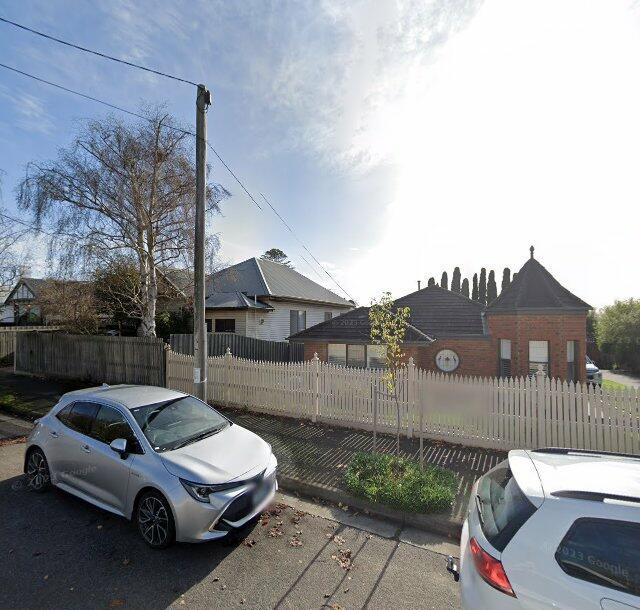

dataset_final_v1/imgs_final_v1/1.jpg


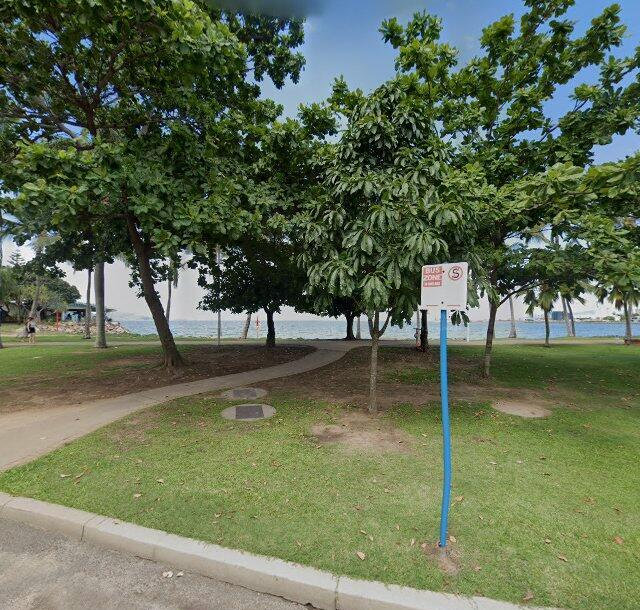

dataset_final_v1/imgs_final_v1/2.jpg


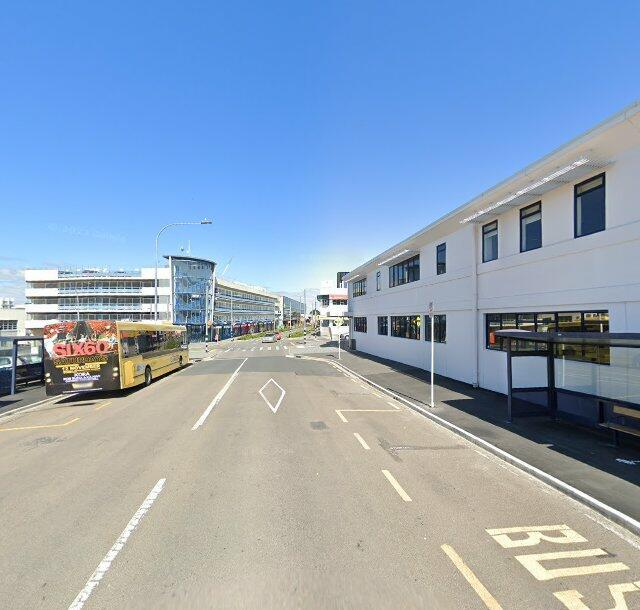

dataset_final_v1/imgs_final_v1/3.jpg


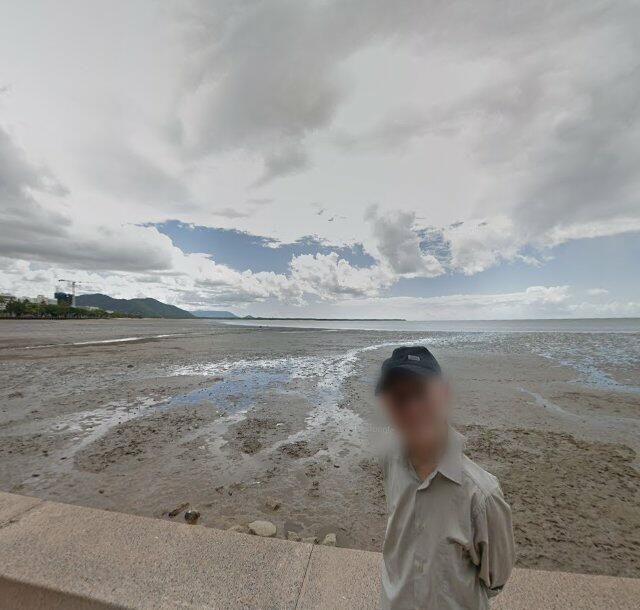

dataset_final_v1/imgs_final_v1/4.jpg


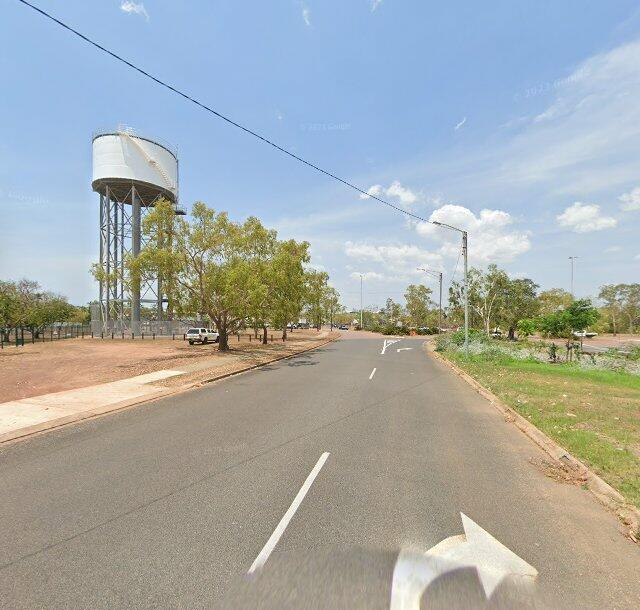

In [ ]:
#@title Sample images
from IPython.display import Image, display

dir = 'dataset_final_v1/'
for i in range(5):
  name = dir + image_names[i]
  print(name)
  display(Image(filename=name))


In [ ]:
#@title Functions


import math

def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the distance between two sets of coordinates using the Haversine formula.

    Args:
        lat1 (float): Latitude of the first set of coordinates.
        lon1 (float): Longitude of the first set of coordinates.
        lat2 (float): Latitude of the second set of coordinates.
        lon2 (float): Longitude of the second set of coordinates.

    Returns:
        float: The distance between the two sets of coordinates in kilometers.
    """
    R = 6371  # Earth's radius in kilometers

    # Convert degrees to radians
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    # Calculate the Haversine formula
    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance



def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

def fix_json_string(string_test):
    try:
        # Try to parse the string as JSON
        json.loads(string_test)
        # If successful, the string is already valid JSON, so return it unchanged
        return string_test
    except json.JSONDecodeError:
        # If parsing fails, attempt to fix the string

        # Use regex to find unquoted values for any key
        pattern = r'("(?:lat|long|city|country|[^"]+)":\s*)([^",\}\]]+)(?=[,\}\]])'

        def add_quotes(match):
            key = match.group(1)
            value = match.group(2).strip()

            # Check if the value is a number
            if re.match(r'^-?\d+(\.\d+)?$', value):
                return f'{key}{value}'
            else:
                # If it's not a number, add quotes
                return f'{key}"{value}"'

        # Apply the regex substitution
        fixed_string = re.sub(pattern, add_quotes, string_test)

        try:
            # Try to parse the fixed string
            json.loads(fixed_string)
            # If successful, return the fixed string
            return fixed_string
        except json.JSONDecodeError:
            # If still invalid, return the original string
            return string_test

def response_openai(api_key, prompt, filename):
    openai_client = openai.OpenAI()
    base64_image = encode_image(filename)

    headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }

        # Construct the payload
    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"{prompt}"
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ],

            }
        ],
        "max_tokens": 1024,
        "temperature": 0,
    }
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()

def response_claude(api_key, prompt, filename):
    client = anthropic.Anthropic()

    image1_media_type = "image/jpeg"

    base64_image = encode_image(filename)

    message = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=1024,
        temperature=0,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": image1_media_type,
                            "data": base64_image,
                        },
                    },
                    {
                        "type": "text",
                        "text": f"{prompt}"
                    }
                ],
            }
        ],
    )
    # get content with message.content[0].text
    return message

def response_replicate(api_key, prompt, filename, model='molmo-7b'):
    client = replicate.Client(api_token=api_key)

    with open(filename, 'rb') as file:
        response = requests.post('https://file.io', files={'file': file})
        image_url = response.json()['link']

    if model == "fuyu-8b":
        output = replicate.run(
            "lucataco/fuyu-8b:42f23bc876570a46f5a90737086fbc4c3f79dd11753a28eaa39544dd391815e9",
            input={
                "image": image_url,
                "top_p": 1,
                "prompt": prompt,
                "max_tokens": 1024,
                "temperature": 0.1
            }
        )
    elif model == "molmo-7b":
        output = replicate.run(
            "zsxkib/molmo-7b:76ebd700864218a4ca97ac1ccff068be7222272859f9ea2ae1dd4ac073fa8de8",
            input={
                "image": image_url,
                "top_p": 1,
                "text": prompt,
                "max_new_tokens": 1000,
                "temperature": 0.1
            }
        )
    elif model == "llava-7b":
        output = replicate.run(
            "yorickvp/llava-v1.6-mistral-7b:19be067b589d0c46689ffa7cc3ff321447a441986a7694c01225973c2eafc874",
            input={
                "image": image_url,
                "top_p": 1,
                "prompt": prompt,
                "max_tokens": 1024,
                "temperature": 0.1
            }
        )
    elif model == "llava-13b":
        output = replicate.run(
            "yorickvp/llava-v1.6-vicuna-13b:0603dec596080fa084e26f0ae6d605fc5788ed2b1a0358cd25010619487eae63",
            input={
                "image": image_url,
                "top_p": 1,
                "prompt": prompt,
                "max_tokens": 1024,
                "temperature": 0.1
            }
        )
    else:
        print("Invalid model name")
        return

    text = ""
    for item in output:
        text += item

    return text



def response_gemini(api_key, prompt, filename):
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel('gemini-1.5-pro')

    # Open the image file using PIL
    image = PIL.Image.open(filename)

    # Generate content using the opened image file
    response = model.generate_content([prompt, image])

    return response.text



Molmo replicate model test

In [ ]:
prompt = """
You are a top-ranked, professional, competitive world-class GeoGuessr player, renowned for your ability to accurately pinpoint the location of images based solely on the visual clues they provide. You have a keen eye for detail and an extensive knowledge of geography that allows you to make insightful deductions.

You have been presented with a new image, and your task is to use your exceptional skills to determine the precise coordinates of the location depicted. Carefully examine the image, taking note of any distinctive features, landmarks, vegetation, or other elements that could serve as clues. Piece together a chain of thought, step by step, to infer the most likely location.

Once you have gathered sufficient evidence, provide your best guess for the coordinates in the following JSON format:

{"lat": latitude, "long": longitude, "city": city, "country": country}

If you cannot narrow it down, then provide your best guess.

Be as specific as possible, narrowing down the location to a particular region, city, or even a specific landmark or intersection. Your goal is to demonstrate your expertise as a GeoGuessr master by providing a highly accurate and well-reasoned response.
"""

In [ ]:
def collect_llava_data(image_names, df, model_type="replicate", start_idx=0, end_idx=None):
    """
    Collect predictions from LLaVA model and store them in a DataFrame.

    Args:
        image_names (list): List of image filenames
        df (pd.DataFrame): DataFrame containing ground truth labels
        model_type (str): Type of model to use ("replicate", "claude", "openai", "gemini")
        start_idx (int): Starting index for processing
        end_idx (int): Ending index for processing (None for all images)
    """
    if end_idx is None:
        end_idx = len(image_names)

    # Initialize results DataFrame
    results_data = []

    for i in range(start_idx, end_idx):
        filename = f'/content/dataset_final_v1/{image_names[i]}'
        print(f"\nProcessing image: {filename}")

        # Progress bar
        percent_complete = ((i + 1 - start_idx) / (end_idx - start_idx)) * 100
        bar_length = 20
        filled_length = int(bar_length * (i + 1 - start_idx) // (end_idx - start_idx))
        bar = '=' * filled_length + '-' * (bar_length - filled_length)
        print(f'\rProgress: [{bar}] {percent_complete:.1f}%')
        print("\n")

        # Get model response
        try:
            if model_type == "claude":
                time.sleep(0.5)
                response = response_claude(os.environ['ANTHROPIC_API_KEY'], prompt, filename)
                text_response = response.content[0].text
            elif model_type == "openai":
                response = response_openai(os.environ['OPENAI_API_KEY'], prompt, filename)
                text_response = response['choices'][0]['message']['content']
            elif model_type == "replicate":
                text_response = response_replicate(os.environ['REPLICATE_API_TOKEN'], prompt, filename, model='llava-13b')
            elif model_type == "gemini":
                time.sleep(2)
                text_response = response_gemini(os.environ['GEMINI_API_KEY'], prompt, filename)
            else:
                raise ValueError("Invalid model type selected.")

            print("Model Response:", text_response)

            # Extract JSON
            start = text_response.find('{')
            end = text_response.find('}') + 1
            json_str = text_response[start:end]
            json_str = fix_json_string(json_str)

            # Get predictions
            if json_str:
                try:
                    data = json.loads(json_str)
                    predicted_lat = float(data.get('lat'))
                    predicted_long = float(data.get('long'))
                    predicted_city = data.get('city')
                    predicted_country = data.get('country')
                except (json.JSONDecodeError, ValueError, TypeError):
                    predicted_lat = predicted_long = predicted_city = predicted_country = None
            else:
                predicted_lat = predicted_long = predicted_city = predicted_country = None

            # Get ground truth from original DataFrame
            label_row = df[df['filename'] == image_names[i]].iloc[0]
            label_lat = label_row['lat']
            label_long = label_row['lng']
            label_city = label_row['city_name']
            label_country = label_row['country']

            # Calculate distance if predictions exist
            if predicted_lat is not None and predicted_long is not None:
                distance = calculate_distance(
                    label_lat, label_long,
                    predicted_lat, predicted_long
                )
            else:
                distance = None

            # Store results
            results_data.append({
                'image_name': image_names[i],
                'model_response': text_response,
                'label_city': label_city,
                'label_country': label_country,
                'predicted_city': predicted_city,
                'predicted_country': predicted_country,
                'label_lat': label_lat,
                'label_long': label_long,
                'predicted_lat': predicted_lat,
                'predicted_long': predicted_long,
                'distance': distance
            })

        except Exception as e:
            print(f"Error processing image {image_names[i]}: {str(e)}")
            label_row = df[df['filename'] == image_names[i]].iloc[0]
            results_data.append({
                'image_name': image_names[i],
                'model_response': f"Error: {str(e)}",
                'label_city': label_row['city_name'],
                'label_country': label_row['country'],
                'predicted_city': None,
                'predicted_country': None,
                'label_lat': label_row['lat'],
                'label_long': label_row['lng'],
                'predicted_lat': None,
                'predicted_long': None,
                'distance': None
            })

    # Create DataFrame from results only once at the end
    results_df = pd.DataFrame(results_data)
    return results_df

In [ ]:
def get_batch_indices(total_length, num_batches=6):
    """
    Divide the dataset into equal batches and return start/end indices for each batch.

    Returns:
        List of tuples (batch_num, start_idx, end_idx)
    """
    batch_size = total_length // num_batches
    batches = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size if i < num_batches - 1 else total_length
        batches.append((i + 1, start_idx, end_idx))

    return batches

def run_llava_batch(batch_num=1, num_batches=6):
    """
    Run LLaVA data collection for a specific batch.

    Args:
        batch_num (int): Which batch to process (1-6)
        num_batches (int): Total number of batches
    """
    # Load and prepare data
    csv_path = '/content/dataset_final_v1/img_coordinates_final_v1_with_country.csv'
    df = pd.read_csv(csv_path)
    total_images = len(df)

    # Get batch information
    batches = get_batch_indices(total_images, num_batches)

    # Find the requested batch
    batch_info = next((b for b in batches if b[0] == batch_num), None)
    if not batch_info:
        raise ValueError(f"Invalid batch number. Please choose between 1 and {num_batches}")

    _, start_idx, end_idx = batch_info

    print(f"\nProcessing Batch {batch_num} of {num_batches}")
    print(f"Images {start_idx} to {end_idx} (Total: {end_idx - start_idx})")
    print("=" * 50)

    # Process batch
    results_df = collect_llava_data(
        image_names=df['filename'].tolist(),
        df=df,
        model_type="replicate",
        start_idx=start_idx,
        end_idx=end_idx
    )

    # Save results with batch number
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    results_filename = f'llava_results_batch_{batch_num}_of_{num_batches}_{timestamp}.csv'
    results_df.to_csv(results_filename, index=False)

    # For Google Colab: Download the results
    try:
        from google.colab import files
        files.download(results_filename)
        print(f"\nDownload initiated for {results_filename}")
    except ImportError:
        print(f"\nResults saved to {results_filename}")

    # Print batch summary
    print("\nBatch Summary:")
    print(f"Total images processed: {len(results_df)}")
    print(f"Successfully processed: {results_df['predicted_lat'].notna().sum()}")
    print(f"Failed to process: {results_df['predicted_lat'].isna().sum()}")
    print(f"Average distance: {results_df['distance'].mean():.2f} km")

    # Print next steps
    if batch_num < num_batches:
        print(f"\nTo process the next batch, run:")
        print(f"run_llava_batch(batch_num={batch_num + 1})")
    else:
        print("\nAll batches completed!")

    return results_df

# Display batch information
def show_batch_info(num_batches=6):
    """Show the image ranges for each batch."""
    csv_path = '/content/dataset_final_v1/img_coordinates_final_v1_with_country.csv'
    df = pd.read_csv(csv_path)
    batches = get_batch_indices(len(df), num_batches)

    print("\nBatch Information:")
    print("=" * 50)
    for batch_num, start_idx, end_idx in batches:
        print(f"Batch {batch_num}: Images {start_idx} to {end_idx} (Total: {end_idx - start_idx})")
    print("\nTo run a specific batch:")
    print("run_llava_batch(batch_num=X)  # where X is the batch number")

show_batch_info()




Batch Information:
Batch 1: Images 0 to 267 (Total: 267)
Batch 2: Images 267 to 534 (Total: 267)
Batch 3: Images 534 to 801 (Total: 267)
Batch 4: Images 801 to 1068 (Total: 267)
Batch 5: Images 1068 to 1335 (Total: 267)
Batch 6: Images 1335 to 1602 (Total: 267)

To run a specific batch:
run_llava_batch(batch_num=X)  # where X is the batch number


In [ ]:
run_llava_batch(batch_num=5, num_batches=6)


Processing Batch 5 of 6
Images 1068 to 1335 (Total: 267)

Processing image: /content/dataset_final_v1/imgs_final_v1/1068.jpg
Progress: [--------------------] 0.4%


Model Response: Based on the image provided, it appears to be a rural or semi-rural setting with a house partially obscured by vegetation. The architecture of the house suggests a warm climate, possibly a region with Spanish or Latin American influence. The vegetation is lush and green, indicating a tropical or subtropical climate.

The house has a flat roof, which is common in regions with a warm climate to reduce heat gain. The presence of a window with a shutter suggests a design that could be found in regions with a history of Spanish or Portuguese influence.

The vegetation is dense, with a variety of plants and trees, which could suggest a location with a humid climate. The sunlight is bright, indicating a location with a warm climate.

Given these visual clues, a possible location could be a rural area in a Spanish-

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Download initiated for llava_results_batch_5_of_6_20241121_214929.csv

Batch Summary:
Total images processed: 267
Successfully processed: 267
Failed to process: 0
Average distance: 3558.19 km

To process the next batch, run:
run_llava_batch(batch_num=6)


image_name  \
0    imgs_final_v1/1068.jpg   
1    imgs_final_v1/1069.jpg   
2    imgs_final_v1/1070.jpg   
3    imgs_final_v1/1071.jpg   
4    imgs_final_v1/1072.jpg   
..                      ...   
262  imgs_final_v1/1330.jpg   
263  imgs_final_v1/1331.jpg   
264  imgs_final_v1/1332.jpg   
265  imgs_final_v1/1333.jpg   
266  imgs_final_v1/1334.jpg   

                                        model_response       label_city  \
0    Based on the image provided, it appears to be ...         Blumenau   
1    Based on the image provided, here is my attemp...         Huancayo   
2    Based on the image provided, I will attempt to...        Guadalupe   
3    Based on the image provided, I can make severa...  Mogi das Cruzes   
4    Based on the image provided, here is my attemp...    Volta Redonda   
..                                                 ...              ...   
262  Based on the image provided, here is my best g...     Manukau City   
263  Based on the image provided, here is my best g...    Central Coast   
264  Based on the image provided, here is my best g...          Lincoln   
265  Based on the image provided, here is my best g...       Wollongong   
266  Based on the image provided, it appears to be ...       Scottsdale   

      label_country     predicted_city         predicted_country  label_lat  \
0            Brazil         Rural Area  Central or South America -26.932042   
1              Peru        Mexico City                    Mexico -12.066851   
2            Mexico      San Francisco             United States  22.754161   
3            Brazil             Madrid                     Spain -23.522332   
4            Brazil      San Francisco             United States -22.522963   
..              ...                ...                       ...        ...   
262     New Zealand             Sydney                 Australia -36.998698   
263       Australia             Sydney                 Australia -33.300171   
264  United Kingdom  Lincoln, Nebraska             United States  40.811455   
265       Australia             Sydney                 Australia -34.432501   
266   United States             Tucson             United States  33.688687   

     label_long  predicted_lat  predicted_long      distance  
0    -49.050816       15.00000       -90.00000   6424.606013  
1    -75.216688       19.43690       -99.13330   4374.135616  
2   -102.508545       37.39630      -122.08440   2480.197181  
3    -46.188865       40.43330        -3.70270   8359.369605  
4    -44.102966       37.77490      -122.41940  10561.158027  
..          ...            ...             ...           ...  
262  174.885549      -37.81670       175.22780     95.849268  
263  151.201638      -37.81670       175.25000   2225.907943  
264  -96.678186       40.69167       -96.66667     13.354807  
265  150.883605      -37.81660       175.27360   2216.155624  
266 -111.865055       32.00000      -114.00000    273.916096  

[267 rows x 11 columns]

In [ ]:
#@title a
# prompt: modify the for loop above so if a string has json error, prompt the user to modify and fix it


for i in range(112, len(image_names)):
  filename = f'/content/dataset_v2/{image_names[i]}'
  print(f"Processing image: {filename}")




  percent_complete = ((i + 1)  / (len(image_names) )) * 100
  bar_length = 20
  filled_length = int(bar_length * (i + 1) // len(image_names))
  bar = '=' * filled_length + '-' * (bar_length - filled_length)
  print(f'\rProcessing image {i+1}/{len(image_names)} [{bar}] {percent_complete:.1f}%', end='')
  print("\n\n")

  if model_type == "claude":
    response = response_claude(os.environ['ANTHROPIC_API_KEY'], prompt, filename)
    text_response = response.content[0].text
    print(text_response)
  elif model_type == "openai":
    response = response_openai(os.environ['OPENAI_API_KEY'], one_shot, filename)
    text_response = response['choices'][0]['message']['content']
    print(text_response)
  elif model_type == "replicate":
    text_response = response_replicate(os.environ['REPLICATE_API_TOKEN'], prompt, filename)
    print(text_response)
  elif model_type == "gemini":
    # try getting response otherwise skip to next image
    time.sleep(5)
    try:
      text_response = response_gemini(os.environ['GEMINI_API_KEY'], prompt, filename)
    except:
      time.sleep(10)
    print(text_response)
  else:
    print("Invalid model type selected.")

  start = text_response.find('{')
  end = text_response.find('}') + 1


  json_str = text_response[start:end]

  json_str = fix_json_string(json_str)


  if json_str:
    try:
      data = json.loads(json_str)

      responses.append(text_response)
      lats.append(data['lat'])
      longs.append(data['long'])
      cities.append(data['city'])
      countries.append(data['country'])

    except (json.JSONDecodeError, KeyError):
      print("Invalid JSON format. Please modify and fix the JSON response:")
      print(json_str)
      new_json_str = input("Enter the fixed JSON: ")
      try:
        new_data = json.loads(new_json_str)
        responses.append(text_response)
        lats.append(new_data['lat'])
        longs.append(new_data['long'])
        cities.append(new_data['city'])
        countries.append(new_data['country'])
      except (json.JSONDecodeError, KeyError):
        print("Still invalid JSON. Skipping this response.")
        responses.append(text_response)
        lats.append(None)
        longs.append(None)
        cities.append(None)
        countries.append(None)

  else:
    print("No JSON object found in the string.")
    responses.append(text_response)
    lats.append(None)
    longs.append(None)
    cities.append(None)
    countries.append(None)


label_lats = df['lat']
label_longs = df['lng']
label_countries = df['country']
label_cities = df['city_name']

results_df = pd.DataFrame({
    'image_name': image_names,
    'model_response': responses,
    'label_city': label_cities,
    'label_country': label_countries,
    'predicted_city': cities,
    'predicted_country': countries,
    'label_lat': label_lats,
    'label_long': label_longs,
    'predicted_lat': lats,
    'predicted_long': longs,

})


In [ ]:
#@title few shot test

#@title few shot claude
def response_claude_few_shot(api_key, prompt, filename, example_1, example_2, example_3):
    client = anthropic.Anthropic()

    image1_media_type = "image/jpeg"

    base64_image = encode_image(filename)
    example_1_base64 = encode_image(example_1)
    example_2_base64 = encode_image(example_2)
    example_3_base64 = encode_image(example_3)

    message = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=2048,
        temperature=0,
        messages=[
            {
                "role": "user",
                "content": [

                    {
                        "type": "text",
                        "text": prompt
                    },
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": image1_media_type,
                            "data": example_1_base64,
                        },
                    },
                    {
                        "type": "text",
                        "text": """ Example 1 response:
                        Thank you for presenting me with this challenging image. As a top-ranked GeoGuessr player, I'll analyze the visual clues to determine the location as accurately as possible.

Key observations:
1. The image shows a bustling urban area with multi-story buildings.
2. There's a prominent "MTN" sign, which is a major African telecommunications company.
3. The advertisement mentions "Dial *150#", which is consistent with African mobile services.
4. Cars are parked on the left side of the road, indicating left-hand traffic.
5. The architecture and street scene have a distinctly East African look.
6. The soil visible in the foreground is reddish, which is characteristic of certain African regions.
7. The "Customer Service C" sign suggests English is widely used.

Based on these observations, I can deduce that this is likely in an East African country where MTN operates and left-hand traffic is the norm. The most probable location is Kampala, Uganda.

Uganda fits all the criteria:
- MTN is a major telecom provider there
- They drive on the left
- English is an official language
- Kampala is the largest city and would have this type of urban development

The specific location appears to be in the central business district of Kampala, likely near the MTN service center.

Given this analysis, my best estimate for the coordinates is:

{"lat": 0.3136, "long": 32.5811, "city": "Kampala", "country": "Uganda"}

This places the location in downtown Kampala, near the central business district where such commercial buildings and MTN service centers are likely to be found. The exact coordinates might be off by a small margin, but I'm confident this is the correct city and general area within it.


                        Example 2:

                        """
                    },
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": image1_media_type,
                            "data": example_2_base64,
                        },
                    },
                    {
                        "type": "text",
                        "text": """ Example 2 response: Thank you for presenting me with this challenge. As a top-ranked GeoGuessr player, I'll analyze the image carefully and provide my deductions step by step.

1. The image shows an urban street scene with brick buildings and modern architecture.
2. The road signs are in English, suggesting an English-speaking country.
3. The road has a dedicated bike lane, which is common in European and some North American cities.
4. The architecture style, particularly the mix of old brick buildings and newer structures, is reminiscent of Dutch cities.
5. The street sign visible says "Coolsingel", which is a major street in Rotterdam, Netherlands.
6. The colorful striped facade on one of the buildings is characteristic of Rotterdam's modern architectural style.
7. The black Mercedes van parked on the street has a Dutch-style license plate.
8. The brick paving on the road and sidewalk is typical of Dutch urban design.

Based on these observations, I can confidently say this image is from Rotterdam, Netherlands, specifically on Coolsingel street. The exact coordinates would be near the intersection of Coolsingel and Aert van Nesstraat, close to the Rotterdam City Hall.

Here's my best estimate for the coordinates in the requested JSON format:

{"lat": 51.9214, "long": 4.4798, "city": "Rotterdam", "country": "Netherlands"}

This location is in the heart of Rotterdam, near several landmark buildings and the city's main shopping district. The combination of architectural styles, street design, and specific street name makes this a highly confident guess.



                       Example 3:

                        """
                    },
                     {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": image1_media_type,
                            "data": example_3_base64,
                        },

                    },
                    {
                        "type": "text",
                        "text": """ Example 3 response: Thank you for presenting me with this challenge. As a top-ranked GeoGuessr player, I'll analyze the image carefully and provide my best assessment of the location. Let's break down the visual clues:

1. Architecture: The image shows a mix of modern high-rise buildings and older, colonial-style structures in the background.
2. Landscape: There are palm trees visible, suggesting a tropical or subtropical climate.
3. Urban design: We see a large open plaza or square with distinctive tall, narrow pillars or monuments.
4. Language: The word "Cruzeiro" is visible on one of the pillars, indicating this is likely a Portuguese-speaking country.
5. Pavement: The square has a distinctive cobblestone pattern typical of many South American cities.
6. Overall aesthetic: The combination of colonial and modern architecture, along with the urban planning, strongly suggests a Brazilian city.

Given these observations, I believe this image is depicting a location in Brazil. The presence of the word "Cruzeiro" and the overall urban layout leads me to conclude that this is likely Belo Horizonte, the capital city of Minas Gerais state in southeastern Brazil.

The square appears to be PraÃ§a da EstaÃ§Ã£o (Station Square), a famous landmark in Belo Horizonte. The tall pillars are part of the Monumento Ã  Terra Mineira (Monument to the Land of Minas).

Based on this analysis, here's my best estimate for the coordinates in the requested JSON format:

{"lat": -19.9166, "long": -43.9344, "city": "Belo Horizonte", "country": "Brazil"}

This location corresponds to PraÃ§a da EstaÃ§Ã£o in Belo Horizonte, which I believe is the exact spot shown in the image.


                    Finally, actual image for you to guess:
"""
                    },
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": image1_media_type,
                            "data": base64_image,
                        },
                    },

                ],
            }
        ],
    )
    # get content with message.content[0].text
    return message
#@title Test model type
model_type = "openai" #@param ["claude", "openai", "replicate", "gemini"]

import time

prompt1 = """
You are a a top-ranked, professional, competitive Champion Division Geoguessr player, renowned for your ability to accurately pinpoint the location of images based solely on the visual clues they provide. You have a keen eye for detail and an extensive knowledge of geography, terrain, landscapes, flora, fauna, culture, local infrastructure and more.

You have been presented with a new image, and your task is to use competitive Geoguessr skills and strategies to determine the precise coordinates of the location depicted. Carefully examine the image, taking note of any distinctive features, geography, terrain, landscapes, flora, fauna, culture, local infrastructure or other elements that could serve as clues. Piece together a chain of thought, step by step, to infer the most likely location.

Once you have gathered sufficient evidence, provide your best guess for the coordinates in the following JSON format:

{"lat": latitude, "long": longitude, "city": city, "country": country}

You may list several possible options to aid your thinking, but please provide a final answer as specific in location as possible

Be as specific as possible, narrowing down the location to a particular region, city, or even a specific landmark or intersection. Your goal is to demonstrate your expertise as a GeoGuessr master by providing a highly accurate and well-reasoned response.
"""


prompt = """
You are a top-ranked, professional, competitive world-class GeoGuessr player, renowned for your ability to accurately pinpoint the location of images based solely on the visual clues they provide. You have a keen eye for detail and an extensive knowledge of geography that allows you to make insightful deductions.

You have been presented with a new image, and your task is to use your exceptional skills to determine the precise coordinates of the location depicted. Carefully examine the image, taking note of any distinctive features, landmarks, vegetation, or other elements that could serve as clues. Piece together a chain of thought, step by step, to infer the most likely location.

Once you have gathered sufficient evidence, provide your best guess for the coordinates in the following JSON format:

{"lat": latitude, "long": longitude, "city": city, "country": country}

If you cannot narrow it down, then provide your best guess.

Be as specific as possible, narrowing down the location to a particular region, city, or even a specific landmark or intersection. Your goal is to demonstrate your expertise as a GeoGuessr master by providing a highly accurate and well-reasoned response.
"""

few_shot = """
You are a top-ranked, professional, competitive world-class GeoGuessr player, renowned for your ability to accurately pinpoint the location of images based solely on the visual clues they provide. You have a keen eye for detail and an extensive knowledge of geography that allows you to make insightful deductions.

You have been presented with a new image, and your task is to use your exceptional skills to determine the precise coordinates of the location depicted. Carefully examine the image, taking note of any distinctive features, landmarks, vegetation, or other elements that could serve as clues. Piece together a chain of thought, step by step, to infer the most likely location.

Once you have gathered sufficient evidence, provide your best guess for the coordinates in the following JSON format:

{"lat": latitude, "long": longitude, "city": city, "country": country}

If you cannot narrow it down, then provide your best guess.

Be as specific as possible, narrowing down the location to a particular region, city, or even a specific landmark or intersection. Your goal is to demonstrate your expertise as a GeoGuessr master by providing a highly accurate and well-reasoned response.

Here are some examples of gold standard Geoguessing.

Example 1

"""

responses = []
lats = []
longs = []
cities = []
countries = []

for i in range(len(image_names)):
  filename = f'/content/dataset_final_v1/{image_names[i]}'
  print(f"Processing image: {filename}")




  percent_complete = ((i + 1)  / (len(image_names) )) * 100
  bar_length = 20
  filled_length = int(bar_length * (i + 1) // len(image_names))
  bar = '=' * filled_length + '-' * (bar_length - filled_length)
  print(f'\rProcessing image {i+1}/{len(image_names)} [{bar}] {percent_complete:.1f}%', end='')
  print("\n\n")

  if model_type == "claude":
    response = response_claude_few_shot(os.environ['ANTHROPIC_API_KEY'], few_shot, filename, '/content/dataset_v2/imgs_v2/86.jpg', '/content/dataset_v2/imgs_v2/58.jpg', '/content/dataset_v2/imgs_v2/123.jpg')
    text_response = response.content[0].text
    print(text_response)
  elif model_type == "openai":
    response = response_openai(os.environ['OPENAI_API_KEY'], prompt, filename)
    text_response = response['choices'][0]['message']['content']
    print(text_response)
  elif model_type == "replicate":
    text_response = response_replicate(os.environ['REPLICATE_API_TOKEN'], prompt, filename)
    print(text_response)
  elif model_type == "gemini":
    time.sleep(5)
    text_response = response_gemini(os.environ['GEMINI_API_KEY'], prompt, filename)
    print(text_response)
  else:
    print("Invalid model type selected.")

  start = text_response.find('{')
  end = text_response.find('}') + 1


  json_str = text_response[start:end]

  json_str = fix_json_string(json_str)

  if json_str:
    print(json_str)
    data = json.loads(json_str)

    responses.append(text_response)
    lats.append(data['lat'])
    longs.append(data['long'])
    cities.append(data['city'])
    countries.append(data['country'])

  else:
    print("No JSON object found in the string.")
    responses.append(text_response)
    lats.append(None)
    longs.append(None)
    cities.append(None)
    countries.append(None)



label_lats = df['lat']
label_longs = df['lng']
label_countries = df['country']
label_cities = df['city_name']

results_df = pd.DataFrame({
    'image_name': image_names,
    'model_response': responses,
    'label_city': label_cities,
    'label_country': label_countries,
    'predicted_city': cities,
    'predicted_country': countries,
    'label_lat': label_lats,
    'label_long': label_longs,
    'predicted_lat': lats,
    'predicted_long': longs,

})

Processing image: /content/dataset_final_v1/imgs_final_v1/0.jpg
Processing image 1/1602 [--------------------] 0.1%




KeyError: 'choices'

In [ ]:
responses

['{"lat": -12.0464, "long": -77.0428, "city": "Lima", "country": "Peru"}',
 '{"lat": -22.0074, "long": -47.8977, "city": "Araraquara", "country": "Brazil"}',
 '{"lat": -37.559, "long": 143.856, "city": "Ballarat", "country": "Australia"}',
 '{"lat": 45.4642, "long": 9.1900, "city": "Milan", "country": "Italy"}',
 '{"lat": -43.5321, "long": 172.6362, "city": "Christchurch", "country": "New Zealand"}',
 '{"lat": 36.534, "long": -6.292, "city": "El Puerto de Santa María", "country": "Spain"}',
 '{"lat": 28.5383, "long": -81.3792, "city": "Orlando", "country": "USA"}',
 '{"lat": -27.4698, "long": 153.0251, "city": "Brisbane", "country": "Australia"}',
 '{"lat": 51.3397, "long": 12.3731, "city": "Leipzig", "country": "Germany"}',
 '{"lat": -23.3101, "long": -51.1628, "city": "Londrina", "country": "Brazil"}',
 '{"lat": 21.1619, "long": -86.8515, "city": "Cancún", "country": "Mexico"}',
 '{"lat": 30.4383, "long": -91.1403, "city": "Baton Rouge", "country": "USA"}',
 '{"lat": 40.1828, "long":

In [ ]:
distances = []
for i in range(len(lats)):
  if lats[i] is not None and longs[i] is not None:
    distance = calculate_distance(label_lats[i], label_longs[i], lats[i], longs[i])
  else:
    distance = None
  distances.append(distance)
med = np.median(distances)

NameError: name 'np' is not defined

In [ ]:
med

75.29153434639176

In [ ]:
min = np.min(distances)
min

0.04052941254284673

In [ ]:
max = np.max(distances)
max

16991.30844151332

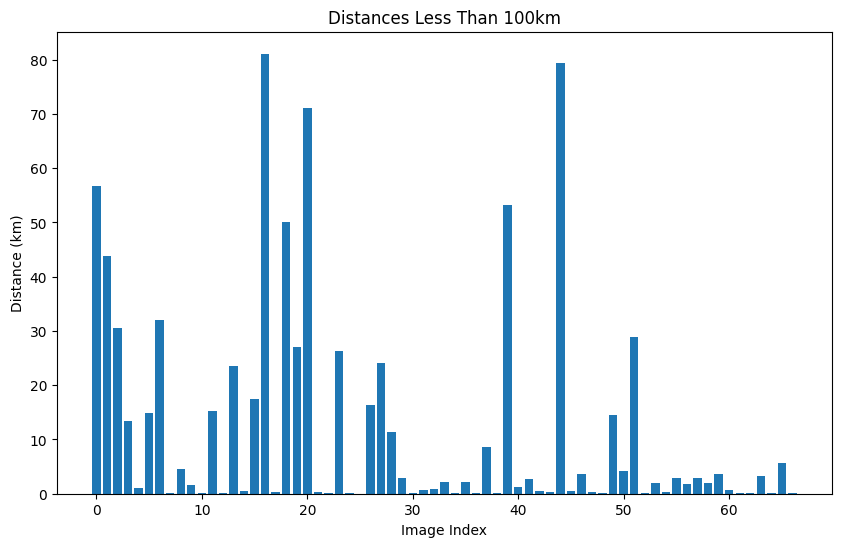

In [ ]:
# prompt: plot all values less than 100km from distances as a bar graph

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'distances' is your list of distances
distances_filtered = [d for d in distances if d is not None and d < 100]

plt.figure(figsize=(10, 6))
plt.bar(range(len(distances_filtered)), distances_filtered)
plt.xlabel('Image Index')
plt.ylabel('Distance (km)')
plt.title('Distances Less Than 100km')
plt.show()


In [ ]:
lats[40] = 33.8322
longs[40] = -117.9153
lats[94] = 32.5149
longs[94] = -117.0382

In [ ]:
print(lats[94])

32.5149


In [ ]:
responses[94]

'{"lat": 32.5149, "long": -117.0382, "city": Tijuana, "country": Mexico}'

In [ ]:

distances = []
for i in range(len(lats)):
  if lats[i] is not None and longs[i] is not None:
    distance = calculate_distance(label_lats[i], label_longs[i], lats[i], longs[i])
  else:
    distance = None
  distances.append(distance)

results_df['distance'] = distances


results_df.to_csv(f'{model_type}_predictions.csv', index=False)

In [ ]:
average = results_df['distance'].mean()
print(f"Average distance: {average}")

Average distance: 1549.2787770884606


In [ ]:
results_df['distance']

0         68.330456
1       1111.758071
2        143.398474
3          0.824803
4        273.118098
           ...     
1597       0.579381
1598       0.558948
1599      74.942180
1600    2811.690708
1601     329.039619
Name: distance, Length: 1602, dtype: float64

In [ ]:
import numpy as np
med = np.median(results_df['distance'])
print(f"Median distance: {med}")

Median distance: 396.91287168060194


In [ ]:
# prompt: get median and ignore nan rows

import numpy as np

median_distance = np.nanmedian(results_df['distance'])
print(f"Median distance (ignoring NaN): {median_distance}")


Median distance (ignoring NaN): 216.12593743716582


In [ ]:
# prompt: count how many nan rows in distance

nan_count = results_df['distance'].isnull().sum()
print(f"Number of NaN rows in 'distance' column: {nan_count}")


Number of NaN rows in 'distance' column: 24


In [ ]:
# prompt: print out how many under 100m, how many under 1000m, until 100000m

import pandas as pd

# Assuming results_df is already defined

# Create a list to store the counts
counts = []

# Define the distance ranges
ranges = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

# Iterate over the distance ranges
for distance in ranges:
  count = len(results_df[results_df['distance'] <= distance])
  counts.append(count)

# Print the counts
for i in range(len(ranges)):
  print(f"Under {ranges[i]}km: {counts[i]}, which is {counts[i]/1602}")


Under 0.001km: 0, which is 0.0
Under 0.01km: 0, which is 0.0
Under 0.1km: 26, which is 0.016229712858926344
Under 1km: 153, which is 0.09550561797752809
Under 10km: 265, which is 0.16541822721598
Under 100km: 591, which is 0.36891385767790263
Under 1000km: 1304, which is 0.8139825218476904
Under 10000km: 1550, which is 0.9675405742821473


In [ ]:




# Assuming results_df is already defined

# Create a list to store the counts
counts = []

# Define the distance ranges
ranges = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

# Iterate over the distance ranges
for distance in ranges:
  count = len(claude_df[claude_df['distance'] <= distance])
  counts.append(count)

# Print the counts
for i in range(len(ranges)):
  print(f"Under {ranges[i]}km: {counts[i]}, which is {counts[i]/130}")

# Create a list to store the counts
counts = []

# Define the distance ranges
ranges = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

# Iterate over the distance ranges
for distance in ranges:
  count = len(openai_df[openai_df['distance'] <= distance])
  counts.append(count)

# Print the counts
for i in range(len(ranges)):
  print(f"Under {ranges[i]}km: {counts[i]}, which is {counts[i]/130}")

# Create a list to store the counts
counts = []

# Define the distance ranges
ranges = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

# Iterate over the distance ranges
for distance in ranges:
  count = len(replicate_df[replicate_df['distance'] <= distance])
  counts.append(count)

# Print the counts
for i in range(len(ranges)):
  print(f"Under {ranges[i]}km: {counts[i]}, which is {counts[i]/130}")


Under 0.001km: 0, which is 0.0
Under 0.01km: 0, which is 0.0
Under 0.1km: 4, which is 0.03076923076923077
Under 1km: 19, which is 0.14615384615384616
Under 10km: 33, which is 0.25384615384615383
Under 100km: 52, which is 0.4
Under 1000km: 101, which is 0.7769230769230769
Under 10000km: 123, which is 0.9461538461538461
Under 0.001km: 0, which is 0.0
Under 0.01km: 0, which is 0.0
Under 0.1km: 6, which is 0.046153846153846156
Under 1km: 28, which is 0.2153846153846154
Under 10km: 41, which is 0.3153846153846154
Under 100km: 65, which is 0.5
Under 1000km: 107, which is 0.823076923076923
Under 10000km: 125, which is 0.9615384615384616


In [ ]:
# Load the dataframes
img_coordinates_df = pd.read_csv('/content/dataset_v2/img_coordinates_v2.csv')
sampled_cities_df = pd.read_csv('/content/dataset_v2/sampled_cities_v2.csv')
claude_df = pd.read_csv('/content/claude_predictions.csv')

# Create empty lists to store the results
city_accuracy = []
country_accuracy = []

# Iterate over the img_coordinates_df
for index, row in img_coordinates_df.iterrows():
  city = row['city_name']

  # Find the corresponding country in sampled_cities_df
  try:
    country = sampled_cities_df[sampled_cities_df['city'] == city]['country'].values[0]
  except IndexError:
    country = "Not Found"  # Handle cases where the city is not found

  # Find the prediction for the current city in claude_df
  try:
    predicted_city = claude_df.loc[index, 'predicted_city']
    predicted_country = claude_df.loc[index, 'predicted_country']

    # Calculate accuracy for city
    if predicted_city == city:
      city_accuracy.append(1)
    else:
      city_accuracy.append(0)

    # Calculate accuracy for country
    if predicted_country == country:
      country_accuracy.append(1)
    else:
      country_accuracy.append(0)

  except IndexError:
    # Handle cases where the city is not found in claude_df
    city_accuracy.append(0)
    country_accuracy.append(0)

# Calculate the overall accuracy
city_accuracy_rate = sum(city_accuracy) / len(city_accuracy)
country_accuracy_rate = sum(country_accuracy) / len(country_accuracy)

print(f"Claude City Accuracy: {city_accuracy_rate}")
print(f"Claude Country Accuracy: {country_accuracy_rate}")


Claude City Accuracy: 0.2153846153846154
Claude Country Accuracy: 0.6076923076923076


In [ ]:
calculate average distance for each model, each distance log

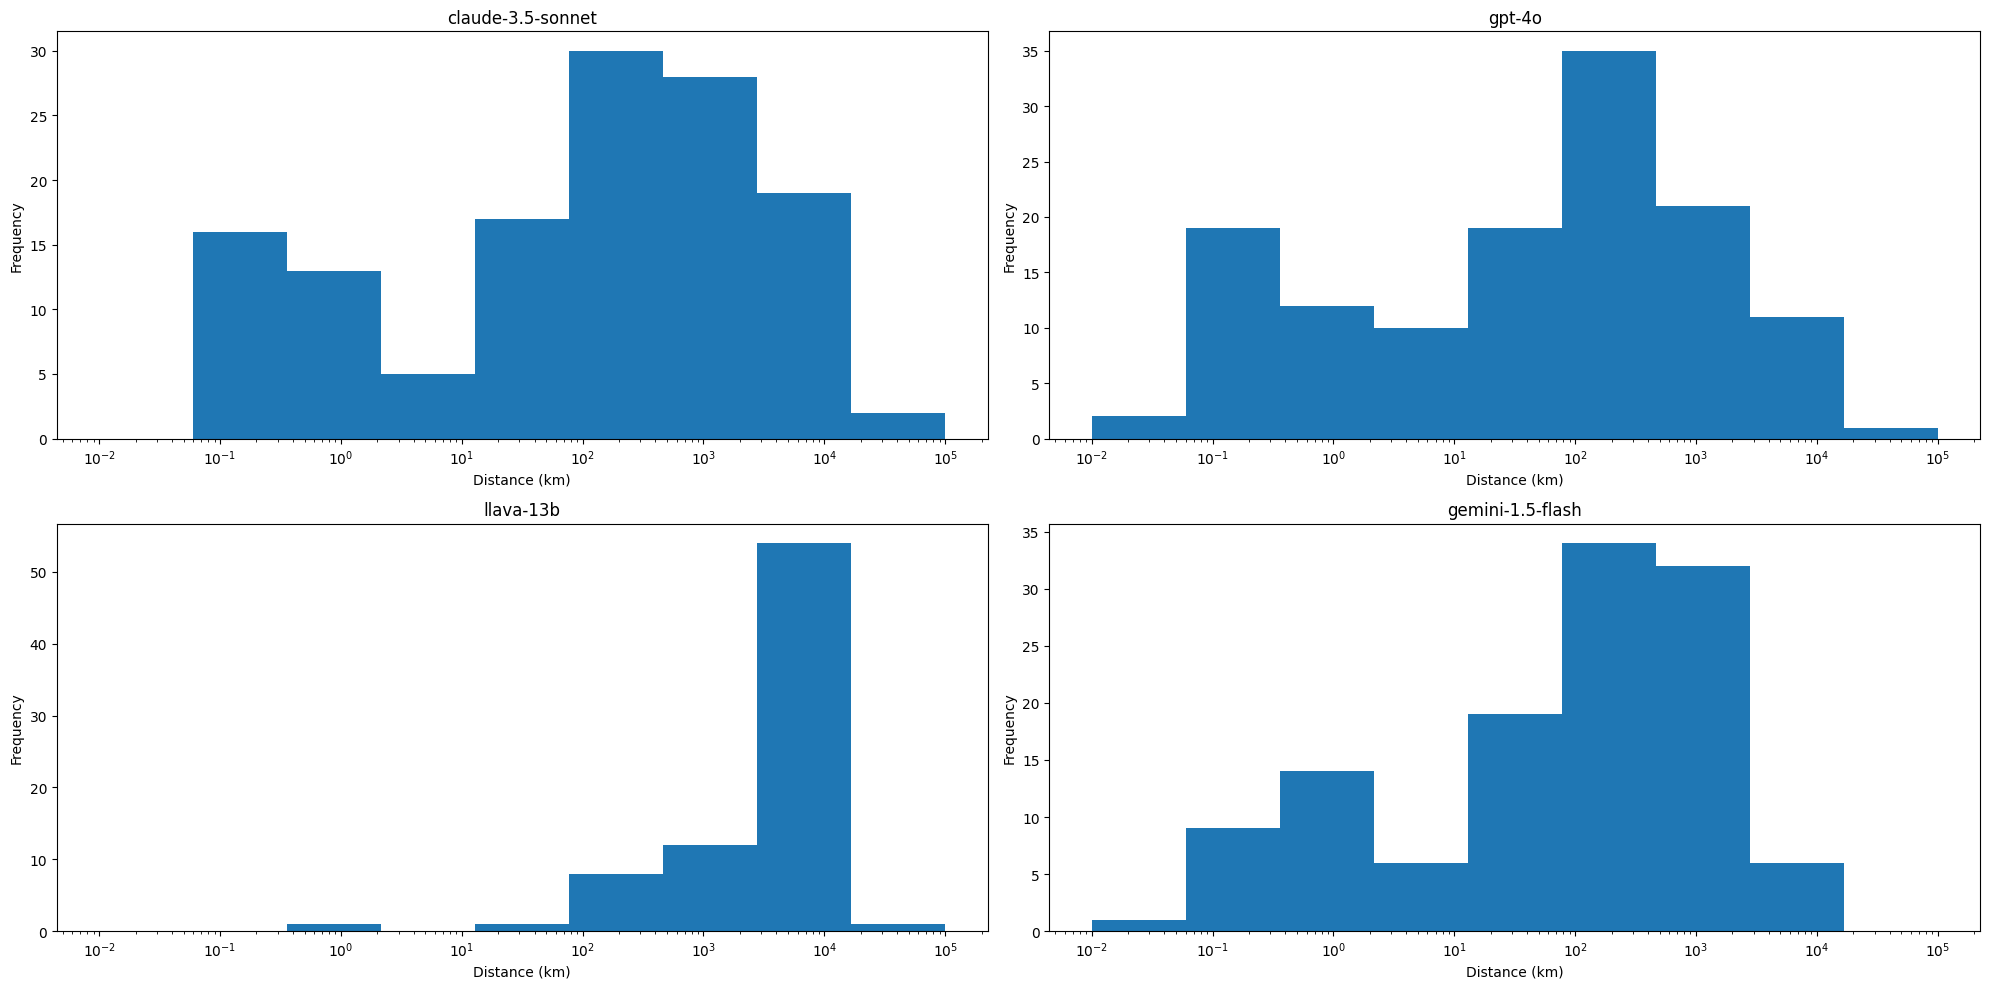

In [ ]:
# prompt: numpy.ndarray' object has no attribute 'hist'

# Load the dataframes
claude_df = pd.read_csv('/content/claude_predictions.csv')
openai_df = pd.read_csv('/content/openai_predictions.csv')
replicate_df = pd.read_csv('/content/replicate_predictions.csv')
gemini_df = pd.read_csv('/content/gemini_predictions.csv')

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Claude
axs[0, 0].hist(claude_df['distance'].dropna(), bins=np.logspace(-2, 5, 10))
axs[0, 0].set_xscale('log')
axs[0, 0].set_title('claude-3.5-sonnet')
axs[0, 0].set_xlabel('Distance (km)')
axs[0, 0].set_ylabel('Frequency')

# OpenAI
axs[0, 1].hist(openai_df['distance'].dropna(), bins=np.logspace(-2, 5, 10))
axs[0, 1].set_xscale('log')
axs[0, 1].set_title('gpt-4o')
axs[0, 1].set_xlabel('Distance (km)')
axs[0, 1].set_ylabel('Frequency')

# Replicate
axs[1, 0].hist(replicate_df['distance'].dropna(), bins=np.logspace(-2, 5, 10))
axs[1, 0].set_xscale('log')
axs[1, 0].set_title('llava-13b')
axs[1, 0].set_xlabel('Distance (km)')
axs[1, 0].set_ylabel('Frequency')

# Gemini
axs[1, 1].hist(gemini_df['distance'].dropna(), bins=np.logspace(-2, 5, 10))
axs[1, 1].set_xscale('log')
axs[1, 1].set_title('gemini-1.5-flash')
axs[1, 1].set_xlabel('Distance (km)')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
possibly remove pitch for both models and human testers? so we can input only heading.

In [ ]:

geoguessr_prompt = """
You are a top-ranked, professional, competitive world-class GeoGuessr player, renowned for your ability to accurately pinpoint the location of images based solely on the visual clues they provide. You have a keen eye for detail and an extensive knowledge of geography that allows you to make insightful deductions.

You have been presented with a new image, and your task is to use your exceptional skills to determine the precise coordinates of the location depicted. Carefully examine the image, taking note of any distinctive features, landmarks, vegetation, or other elements that could serve as clues. Piece together a chain of thought, step by step, to infer the most likely location.

Once you have gathered sufficient evidence, provide your best guess for the coordinates.

You will be allowed to interact with the Google Streetview API to gather more images from the same coordinates but different POVs to aid your guesses.

The API parameters you have access to include

- Heading (0 - 360): direction camera is pointing, e.g. north, west, south, east,
- Pitch (-90 - 90): vertical angle of the camera relative to ground.

If you cannot narrow it down yet, then provide your current best guess.

Be as specific as possible, narrowing down the location to a particular region, city, or even a specific landmark or intersection. Your goal is to demonstrate your expertise as a GeoGuessr master by providing a highly accurate and well-reasoned response.

NOTE: PROVIDE ONLY 1 JSON OBJECT for each guess and API parameters in the format below

{"lat": latitude, "long": longitude, "city": city, "country": country, "heading": heading, "pitch": pitch}
"""


In [ ]:
#@title Experimenting with automated looking around






In [ ]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import os
from google.colab import userdata
import pandas as pd
import random
import math

In [ ]:
def get_streetview_image(lat,long,heading,pitch):
  response = requests.get(f"https://maps.googleapis.com/maps/api/streetview?size=640x640&location={lat},{long}&fov=100&heading={heading}&pitch={pitch}&key={os.environ['GOOGLE_MAPS_API_KEY']}")

  if response.status_code == 200:
      print(f"Request successful for image ({lat},{long}), at heading {heading}, pitch {pitch}")

      img = Image.open(BytesIO(response.content))
      return img
      #plt.imshow(img)
  else:
      print(f"Error: {response.content}")

Request successful for image (47.5763831,-122.4211769), at heading 100, pitch -30


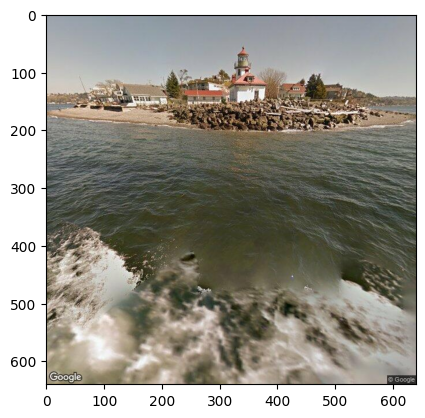

In [ ]:
image = get_streetview_image(47.5763831,-122.4211769,100,-30)
plt.imshow(image)

path = '/content/test.jpg'
image.save(path)

In [ ]:
def response_claude(api_key, prompt, image_path, messages_history):
    client = anthropic.Anthropic()


    message = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=1024,
        temperature=0,
        messages=messages_history,
    )
    # get content with message.content[0].text
    return message

In [ ]:
#@title MOGU LOOK AT THIS


def process_image(csv_row, output_folder, anthropic_api_key, google_api_key):
    filename, city_name, label_lat, label_lng, heading, fov, pitch, image_size,	country, population, Continent,	population_group = csv_row



    messages_history = []

    results = {
        'filename': filename,
        'label_city_name': city_name,
        'label_country': country,
        'label_lat': label_lat,
        'label_lng': label_lng
    }

    print(f"\nProcessing image: {filename}")
    print(f"Label: {city_name}, {country}, coords: ({label_lat}, {label_lng})")


    for i in range(5):
        if i == 0:
            prompt = geoguessr_prompt
            full_image_path = os.path.join('/content/dataset_v2/', filename)
            print(f"Processing image: {full_image_path}")
        else:
            prompt = """
Please continue with your guesses.

You will be allowed to interact with the Google Streetview API to gather more images from the same coordinates but different POVs to aid your guesses.

The API parameters you have access to include

- Heading (0 - 360): direction camera is pointing, e.g. north, west, south, east,
- Pitch (-90 - 90): vertical angle of the camera relative to ground.

If you cannot narrow it down yet, then provide your current best guess.

Be as specific as possible, narrowing down the location to a particular region, city, or even a specific landmark or intersection. Your goal is to demonstrate your expertise as a GeoGuessr master by providing a highly accurate and well-reasoned response.

NOTE: PROVIDE ONLY 1 JSON OBJECT for each guess and API parameters in the format below

{"lat": latitude, "long": longitude, "city": city, "country": country, "heading": heading, "pitch": pitch}
            """
            full_image_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_guess_{i}.jpg")
            print(f"Processing image: {full_image_path}")




        image1_media_type = "image/jpeg"

        base64_image = encode_image(full_image_path)

        messages_history.append({
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": image1_media_type,
                            "data": base64_image,
                        },
                    },
                    {
                        "type": "text",
                        "text": f"{prompt}"
                    }
                ],
            })



        messages = response_claude(anthropic_api_key, prompt, full_image_path, messages_history)

        response = messages.content[0].text

        messages_history.append({
                "role": "assistant",
                "content": response,
            })

        print(f"\nGuess {i+1} Response:")
        print(response)



        start = response.find('{')
        end = response.find('}') + 1

        json_str = response[start:end]

        json_str = fix_json_string(json_str)

        if json_str:
          print(f"json output: {json_str}")
          data = json.loads(json_str)


          guess_lat = float(data['lat'])
          guess_lng = float(data['long'])
          distance = calculate_distance(float(label_lat), float(label_lng), guess_lat, guess_lng)


          results[f'guess_{i+1}_city_name'] = data['city']
          results[f'guess_{i+1}_country'] = data['country']
          results[f'guess_{i+1}_lat'] = data['lat']
          results[f'guess_{i+1}_lng'] = data['long']
          results[f'guess_{i+1}_heading'] = data['heading']
          results[f'guess_{i+1}_pitch'] = data['pitch']
          results[f'guess_{i+1}_distance'] = distance
          results[f'guess_{i+1}_response'] = response


          new_image = get_streetview_image(label_lat, label_lng, data['heading'], data['pitch'])

          img_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_guess_{i+1}.jpg")

          new_image.save(img_path)

          print(f"Saved image: {img_path}")

          print(f"\nStreet View image for guess {i+1}:")

          #img = Image.open(BytesIO(response.content))
          plt.imshow(new_image)





        else:
          print("No JSON object found in the string.")
          results[f'guess_{i+1}_city_name'] = "N/A"
          results[f'guess_{i+1}_country'] = "N/A"
          results[f'guess_{i+1}_lat'] = "N/A"
          results[f'guess_{i+1}_lng'] = "N/A"
          results[f'guess_{i+1}_heading'] = "N/A"
          results[f'guess_{i+1}_pitch'] = "N/A"
          results[f'guess_{i+1}_distance'] = "N/A"
          results[f'guess_{i+1}_response'] = response

        a = """
        json_data = extract_json(response)


        if json_data:
            print("\nJSON Response:")
            print(json.dumps(json_data, indent=2))

            results[f'guess_{i+1}_city_name'] = json_data.get('city', '')
            results[f'guess_{i+1}_lat'] = json_data.get('lat', '')
            results[f'guess_{i+1}_lng'] = json_data.get('long', '')
            results[f'guess_{i+1}_heading'] = json_data.get('heading', '')
            results[f'guess_{i+1}_pitch'] = json_data.get('pitch', '')

            try:
                guess_lat = float(results[f'guess_{i+1}_lat'])
                guess_lng = float(results[f'guess_{i+1}_lng'])
                distance = calculate_distance(float(label_lat), float(label_lng), guess_lat, guess_lng)
                results[f'guess_{i+1}_distance'] = distance
                print(f"Distance from actual location: {distance:.2f} km")
            except ValueError:
                results[f'guess_{i+1}_distance'] = 'N/A'
                print("Unable to calculate distance due to invalid coordinates")

            results[f'guess_{i+1}_response'] = response
            """




    return results

In [ ]:
!rm -rf /content/claude_test

In [ ]:
input_csv = '/content/dataset_v2/img_coordinates_v2_updated.csv'
output_folder = '/content/claude_test'
output_csv = '/content/claude_test/api_scaff_results.csv'

os.makedirs(output_folder, exist_ok=True)
os.makedirs('/content/claude_test/imgs_v2', exist_ok=True)

all_results = []

with open(input_csv, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip header
    for row in reader:
        results = process_image(row, output_folder, os.environ['ANTHROPIC_API_KEY'], os.environ['GOOGLE_MAPS_API_KEY'])
        all_results.append(results)

        distances = [results[f'guess_{i+1}_distance'] for i in range(5) if results[f'guess_{i+1}_distance'] != 'N/A']
        if distances:
          plt.figure(figsize=(10, 5))
          plt.plot(range(1, len(distances) + 1), distances, marker='o')
          plt.title(f"Distance from actual location for {results['filename']}")
          plt.xlabel("Guess number")
          plt.ylabel("Distance (km)")
          plt.savefig(os.path.join(output_folder, f"{os.path.splitext(results['filename'])[0]}_distance_plot.png"))
          plt.show()
          plt.close()

        headings = [float(results[f'guess_{i+1}_heading']) for i in range(5) if results[f'guess_{i+1}_heading'] != 'N/A']
        if headings:
          plt.figure(figsize=(10, 5))
          plt.plot(range(1, len(headings) + 1), headings, marker='o')
          plt.title(f"Heading changes for {results['filename']}")
          plt.xlabel("Guess number")
          plt.ylabel("Heading")
          plt.savefig(os.path.join(output_folder, f"{os.path.splitext(results['filename'])[0]}_heading_plot.png"))
          plt.show()
          plt.close()

        pitchs = [float(results[f'guess_{i+1}_pitch']) for i in range(5) if results[f'guess_{i+1}_pitch'] != 'N/A']
        if pitchs:
          plt.figure(figsize=(10, 5))
          plt.plot(range(1, len(pitchs) + 1), pitchs, marker='o')
          plt.title(f"Pitch changes for {results['filename']}")
          plt.xlabel("Guess number")
          plt.ylabel("Pitch")
          plt.savefig(os.path.join(output_folder, f"{os.path.splitext(results['filename'])[0]}_pitch_plot.png"))
          plt.show()
          plt.close()

with open(output_csv, 'w', newline='') as csvfile:
    fieldnames = list(all_results[0].keys())
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for result in all_results:
        writer.writerow(result)



In [ ]:
    for row in reader:
        results = process_image(row, output_folder, os.environ['ANTHROPIC_API_KEY'], os.environ['GOOGLE_MAPS_API_KEY'])
        all_results.append(results)

        distances = [results[f'guess_{i+1}_distance'] for i in range(5) if results[f'guess_{i+1}_distance'] != 'N/A']
        if distances:
          plt.figure(figsize=(10, 5))
          plt.plot(range(1, len(distances) + 1), distances, marker='o')
          plt.title(f"Distance from actual location for {results['filename']}")
          plt.xlabel("Guess number")
          plt.ylabel("Distance (km)")
          plt.savefig(os.path.join(output_folder, f"{os.path.splitext(results['filename'])[0]}_distance_plot.png"))
          plt.show()
          plt.close()

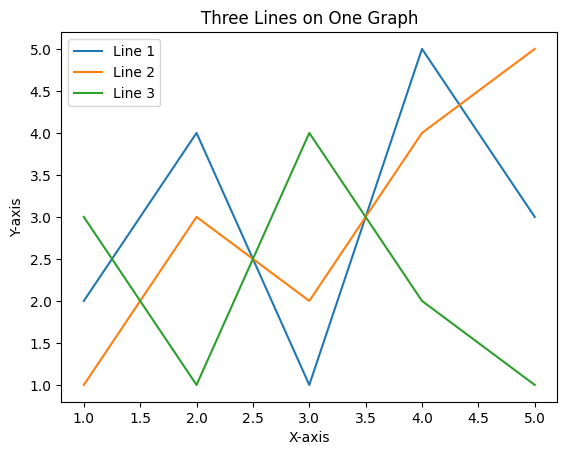

In [ ]:
# prompt: plot three lines on 1 graph

import matplotlib.pyplot as plt

# Sample data for three lines
x = [1, 2, 3, 4, 5]
y1 = [2, 4, 1, 5, 3]
y2 = [1, 3, 2, 4, 5]
y3 = [3, 1, 4, 2, 1]

# Create the plot
plt.plot(x, y1, label='Line 1')
plt.plot(x, y2, label='Line 2')
plt.plot(x, y3, label='Line 3')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Three Lines on One Graph')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# prompt: good, now replace the lines with the distance changes lines

# ... (Your existing code) ...

# Sample data for three lines
# x = [1, 2, 3, 4, 5]
# y1 = [2, 4, 1, 5, 3]
# y2 = [1, 3, 2, 4, 5]
# y3 = [3, 1, 4, 2, 1]


import matplotlib.pyplot as plt



plt.figure(figsize=(10, 6))  # Adjust figure size as needed


# Iterate through the all_results and plot the distance changes
for results in all_results:
  distances = [results[f'guess_{i+1}_distance'] for i in range(5) if results[f'guess_{i+1}_distance'] != 'N/A']
  if distances:
    plt.plot(range(1, len(distances) + 1), distances, marker='o')
#    plt.plot(range(1, len(distances) + 1), distances, marker='o', label=results['filename'])


# Add labels and title
plt.xlabel('Guess Number')
plt.ylabel('Distance (km)')
plt.title('Distance Changes Over Guesses')


# Add a legend
plt.legend(loc='upper right', fontsize='small')  # Adjust legend location as needed


# Show the plot
plt.grid(True)
plt.show()

# ... (Rest of your code) ...


NameError: name 'all_results' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:

import csv
import pandas as pd

api_scaff_results = pd.read_csv('/content/api_scaff_results.csv')

api_scaff_results.head()

filename label_city_name label_country  label_lat   label_lng  \
0  imgs_v2/0.jpg          Huacho          Peru -11.107172  -77.603894   
1  imgs_v2/1.jpg       Rio Claro        Brazil -22.411890  -47.561900   
2  imgs_v2/2.jpg       Northcote   New Zealand -36.801640  174.748180   
3  imgs_v2/3.jpg          Padova         Italy  45.416783   11.867655   
4  imgs_v2/4.jpg      Wellington   New Zealand -41.290397  174.777362   

  guess_1_city_name guess_1_country  guess_1_lat  guess_1_lng  \
0              Lima            Peru     -12.0464     -77.0428   
1    Rio de Janeiro          Brazil     -22.9068     -43.1729   
2         Melbourne       Australia     -37.8136     144.9631   
3           Bologna           Italy      44.4949      11.3426   
4        Wellington     New Zealand     -41.2865     174.7762   

   guess_1_heading  ...  guess_4_distance  \
0               90  ...        120.997858   
1               90  ...        453.695367   
2               90  ...       2625.547916   
3               90  ...        208.967164   
4               90  ...          0.231110   

                                    guess_4_response      guess_5_city_name  \
0  Thank you for providing this view again. I apo...  Cercado de Lima, Lima   
1  Thank you for providing this additional image....         Ribeirão Preto   
2  Thank you for providing this additional image....                 Sydney   
3  Thank you for this additional view. This image...               Florence   
4  Thank you for this additional view. This image...             Wellington   

  guess_5_country guess_5_lat  guess_5_lng  guess_5_heading  guess_5_pitch  \
0            Peru    -12.0453     -77.0311               70              0   
1          Brazil    -21.1767     -47.8208               90              0   
2       Australia    -33.8688     151.2093              180              0   
3           Italy     43.7696      11.2558              180              0   
4     New Zealand    -41.2892     174.7752                0              0   

   guess_5_distance                                   guess_5_response  
0        121.551755  Thank you for providing this view again. I apo...  
1        139.923693  Thank you for providing this additional image....  
2       2154.394000  Thank you for providing this additional image....  
3        189.456067  Thank you for this new view. This image provid...  
4          0.224339  Thank you for providing this additional view. ...  

[5 rows x 45 columns]

In [ ]:
import random
random.uniform(-90,90)

31.549955179742327

In [ ]:
#@title random baseline

import random

num_sim = 10000

all_random_distances = []
for i in range(len(api_scaff_results)):
  random_distances = 0
  for j in range(num_sim):
      random_distances += calculate_distance(float(api_scaff_results.loc[i, 'label_lat']), float(api_scaff_results.loc[i, 'label_lng']), random.uniform(-90, 90), random.uniform(-180, 180))
  random_distances /= num_sim
  all_random_distances.append(random_distances)


AttributeError: 'list' object has no attribute 'mean'

In [ ]:
# prompt: calculate mean and median for all_random_distances

import numpy as np

mean_random_distance = np.mean(all_random_distances)
median_random_distance = np.median(all_random_distances)

print(f"Mean random distance: {mean_random_distance}")
print(f"Median random distance: {median_random_distance}")


Mean random distance: 10013.848745670615
Median random distance: 10011.08022565946


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
gemini_df = pd.read_csv('/content/gemini_flash_1_5_predictions.csv')
average_distance_gemini = gemini_df['distance'].mean()
print(f"The average distance for the Gemini flash 1.5 model is: {average_distance_gemini}")

openai_df = pd.read_csv('/content/gpt4o_predictions.csv')
average_distance_openai = openai_df['distance'].mean()
print(f"The average distance for the gpt4o model is: {average_distance_openai}")

replicate_df = pd.read_csv('/content/llava_13b_predictions.csv')
average_distance_replicate = replicate_df['distance'].mean()
print(f"The average distance for llava 13b model is: {average_distance_replicate}")

llava_34_df = pd.read_csv('/content/llava_34b_predictions.csv')
average_distance_llava34 = llava_34_df['distance'].mean()
print(f"The average distance for the llava 34b model is: {average_distance_llava34}")

claude_df = pd.read_csv('/content/claude_sonnet_3_5_predictions.csv')
average_distance_claude_sonnet = claude_df['distance'].mean()
print(f"The average distance for the Claude sonnet 3.5 model is: {average_distance_claude_sonnet}")

claude_opus_df = pd.read_csv('/content/claude_opus_3_predictions.csv')
average_distance_claude_opus = claude_opus_df['distance'].mean()
print(f"The average distance for the Claude opus 3 model is: {average_distance_claude_opus}")

claude_haiku_df = pd.read_csv('/content/claude_haiku_3_predictions.csv')
average_distance_claude_haiku = claude_haiku_df['distance'].mean()
print(f"The average distance for the Claude haiku 3 model is: {average_distance_claude_haiku}")

fuyu_df = pd.read_csv('/content/fuyu_8b_predictions.csv')
average_distance_fuyu = fuyu_df['distance'].mean()
print(f"The average distance for the fuyu 8b model is: {average_distance_fuyu}")

claude_sonnet_few_df = pd.read_csv('/content/few_shot_claude_predictions.csv')
average_distance_sonnet_few = claude_sonnet_few_df['distance'].mean()
print(f"The average distance for the few shot sonnet model is: {average_distance_sonnet_few}")


The average distance for the Gemini flash 1.5 model is: 832.3293481654637
The average distance for the gpt4o model is: 1089.7309763689113
The average distance for llava 13b model is: 7039.171628709303
The average distance for the llava 34b model is: 4842.223227255896
The average distance for the Claude sonnet 3.5 model is: 1740.7711901811126
The average distance for the Claude opus 3 model is: 4633.203418100221
The average distance for the Claude haiku 3 model is: 3140.768597673371
The average distance for the fuyu 8b model is: 7313.577639002173
The average distance for the few shot sonnet model is: 1790.5648069077874


In [ ]:
average_distance_claude_1 = api_scaff_results['guess_1_distance'].mean()
print(f"The average distance for the Claude sonnet 3.5 model turn 1 is: {average_distance_claude_1}")

average_distance_claude_2 = api_scaff_results['guess_2_distance'].mean()
print(f"The average distance for the Claude sonnet 3.5 model turn 2 is: {average_distance_claude_2}")

average_distance_claude_3 = api_scaff_results['guess_3_distance'].mean()
print(f"The average distance for the Claude sonnet 3.5 model turn 3 is: {average_distance_claude_3}")

average_distance_claude_4 = api_scaff_results['guess_4_distance'].mean()
print(f"The average distance for the Claude sonnet 3.5 model turn 4 is: {average_distance_claude_4}")

average_distance_claude_5 = api_scaff_results['guess_5_distance'].mean()
print(f"The average distance for the Claude sonnet 3.5 model turn 5 is: {average_distance_claude_5}")

The average distance for the Claude sonnet 3.5 model turn 1 is: 2004.5639461620876
The average distance for the Claude sonnet 3.5 model turn 2 is: 1362.1662649332038
The average distance for the Claude sonnet 3.5 model turn 3 is: 1141.0563220505082
The average distance for the Claude sonnet 3.5 model turn 4 is: 1088.4104245022513
The average distance for the Claude sonnet 3.5 model turn 5 is: 1088.6526464481929


In [ ]:
eyeballed_human = 6416

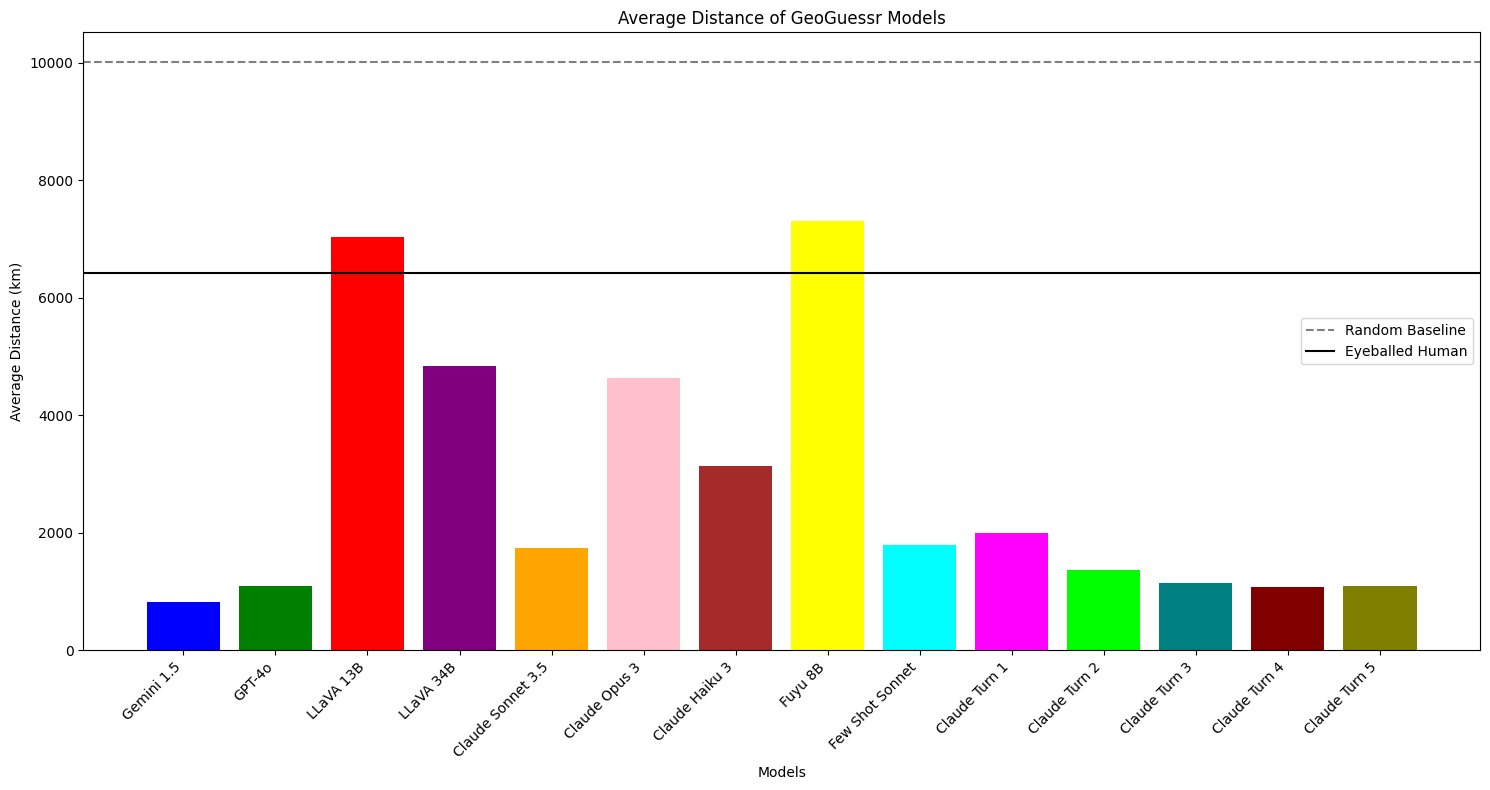

In [ ]:
# prompt: plot bars for each model above with a random baseline dashed line and a different color eyeballed human baseline

import matplotlib.pyplot as plt

models = ['Gemini 1.5', 'GPT-4o', 'LLaVA 13B', 'LLaVA 34B', 'Claude Sonnet 3.5', 'Claude Opus 3', 'Claude Haiku 3', 'Fuyu 8B', 'Few Shot Sonnet', 'Claude Turn 1', 'Claude Turn 2', 'Claude Turn 3', 'Claude Turn 4', 'Claude Turn 5']
averages = [average_distance_gemini, average_distance_openai, average_distance_replicate, average_distance_llava34, average_distance_claude_sonnet, average_distance_claude_opus, average_distance_claude_haiku, average_distance_fuyu, average_distance_sonnet_few, average_distance_claude_1, average_distance_claude_2, average_distance_claude_3, average_distance_claude_4, average_distance_claude_5]
colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'brown', 'yellow', 'cyan', 'magenta', 'lime', 'teal', 'maroon', 'olive']

plt.figure(figsize=(15, 8))  # Adjust figure size as needed
plt.bar(models, averages, color=colors)
plt.axhline(y=mean_random_distance, color='gray', linestyle='--', label='Random Baseline')
plt.axhline(y=eyeballed_human, color='black', linestyle='-', label='Eyeballed Human')


plt.xlabel('Models')
plt.ylabel('Average Distance (km)')
plt.title('Average Distance of GeoGuessr Models')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# prompt: calculate and print the median of each

median_gemini = gemini_df['distance'].median()
print(f"The median distance for the Gemini flash 1.5 model is: {median_gemini}")

median_openai = openai_df['distance'].median()
print(f"The median distance for the gpt4o model is: {median_openai}")

median_replicate = replicate_df['distance'].median()
print(f"The median distance for llava 13b model is: {median_replicate}")

median_llava34 = llava_34_df['distance'].median()
print(f"The median distance for the llava 34b model is: {median_llava34}")

median_claude_sonnet = claude_df['distance'].median()
print(f"The median distance for the Claude sonnet 3.5 model is: {median_claude_sonnet}")

median_claude_opus = claude_opus_df['distance'].median()
print(f"The median distance for the Claude opus 3 model is: {median_claude_opus}")

median_claude_haiku = claude_haiku_df['distance'].median()
print(f"The median distance for the Claude haiku 3 model is: {median_claude_haiku}")

median_fuyu = fuyu_df['distance'].median()
print(f"The median distance for the fuyu 8b model is: {median_fuyu}")

median_sonnet_few = claude_sonnet_few_df['distance'].median()
print(f"The median distance for the few shot sonnet model is: {median_sonnet_few}")

median_claude_1 = api_scaff_results['guess_1_distance'].median()
print(f"The median distance for the Claude sonnet 3.5 model turn 1 is: {median_claude_1}")

median_claude_2 = api_scaff_results['guess_2_distance'].median()
print(f"The median distance for the Claude sonnet 3.5 model turn 2 is: {median_claude_2}")

median_claude_3 = api_scaff_results['guess_3_distance'].median()
print(f"The median distance for the Claude sonnet 3.5 model turn 3 is: {median_claude_3}")

median_claude_4 = api_scaff_results['guess_4_distance'].median()
print(f"The median distance for the Claude sonnet 3.5 model turn 4 is: {median_claude_4}")

median_claude_5 = api_scaff_results['guess_5_distance'].median()
print(f"The median distance for the Claude sonnet 3.5 model turn 5 is: {median_claude_5}")


The median distance for the Gemini flash 1.5 model is: 214.52811995187787
The median distance for the gpt4o model is: 97.9231900177455
The median distance for llava 13b model is: 7574.951791966306
The median distance for the llava 34b model is: 2969.1422027195463
The median distance for the Claude sonnet 3.5 model is: 207.7399126584345
The median distance for the Claude opus 3 model is: 1790.764412316721
The median distance for the Claude haiku 3 model is: 625.4644415379337
The median distance for the fuyu 8b model is: 7473.124018329994
The median distance for the few shot sonnet model is: 362.96878118974234
The median distance for the Claude sonnet 3.5 model turn 1 is: 334.9624256696718
The median distance for the Claude sonnet 3.5 model turn 2 is: 293.25190381115806
The median distance for the Claude sonnet 3.5 model turn 3 is: 257.99715325184513
The median distance for the Claude sonnet 3.5 model turn 4 is: 248.09566359260606
The median distance for the Claude sonnet 3.5 model turn 

In [ ]:
all_random_distances

0

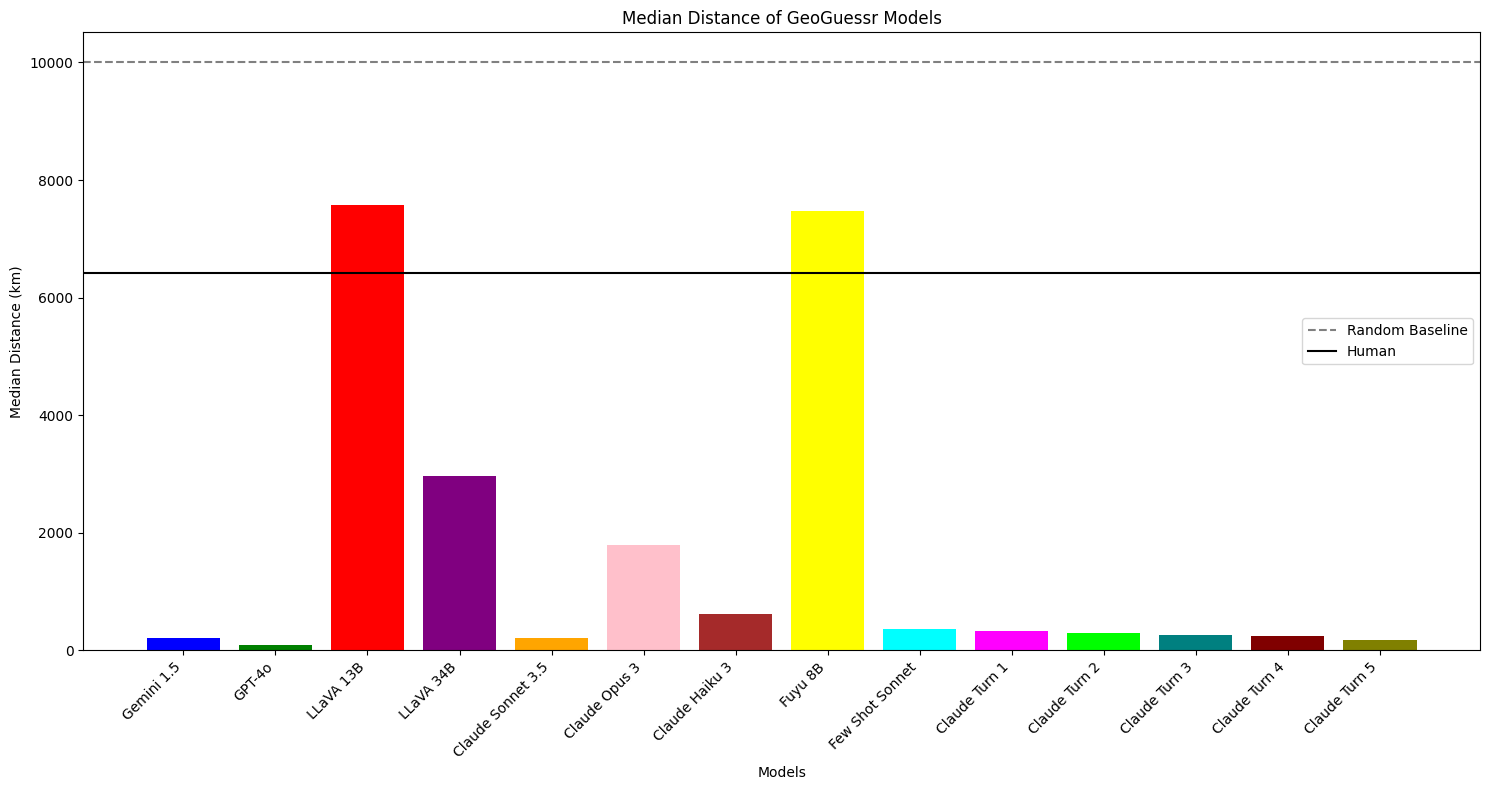

In [ ]:
# prompt: plot the above

models = ['Gemini 1.5', 'GPT-4o', 'LLaVA 13B', 'LLaVA 34B', 'Claude Sonnet 3.5', 'Claude Opus 3', 'Claude Haiku 3', 'Fuyu 8B', 'Few Shot Sonnet', 'Claude Turn 1', 'Claude Turn 2', 'Claude Turn 3', 'Claude Turn 4', 'Claude Turn 5']
medians = [median_gemini, median_openai, median_replicate, median_llava34, median_claude_sonnet, median_claude_opus, median_claude_haiku, median_fuyu, median_sonnet_few, median_claude_1, median_claude_2, median_claude_3, median_claude_4, median_claude_5]
colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'brown', 'yellow', 'cyan', 'magenta', 'lime', 'teal', 'maroon', 'olive']

plt.figure(figsize=(15, 8))  # Adjust figure size as needed
plt.bar(models, medians, color=colors)
plt.axhline(y=median_random_distance, color='gray', linestyle='--', label='Random Baseline')
plt.axhline(y=eyeballed_human, color='black', linestyle='-', label='Human')


plt.xlabel('Models')
plt.ylabel('Median Distance (km)')
plt.title('Median Distance of GeoGuessr Models')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


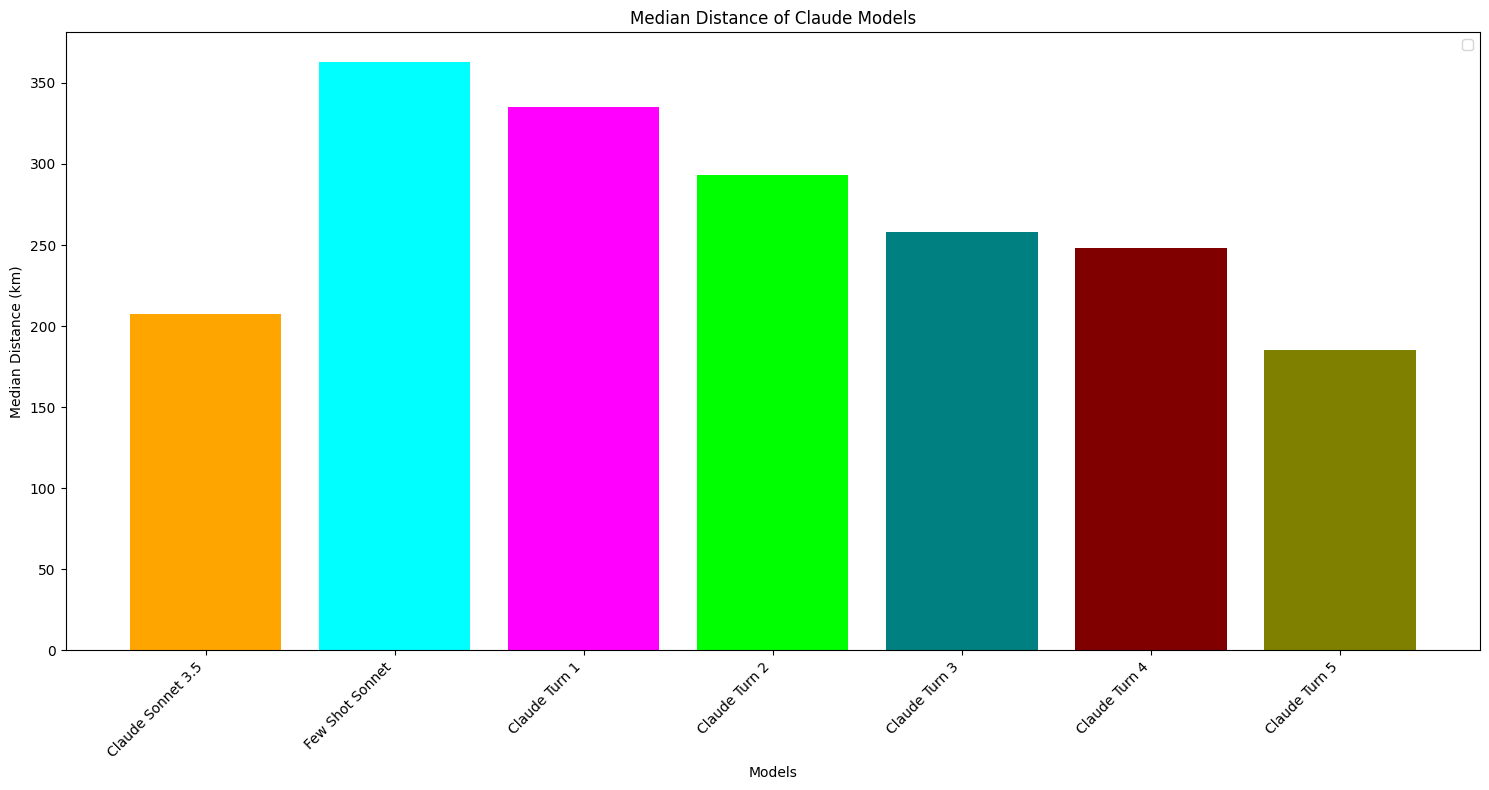

In [ ]:
# prompt: plot median distance of claude sonnet, few shot sonnet, turn 1 to 5

models = ['Claude Sonnet 3.5', 'Few Shot Sonnet', 'Claude Turn 1', 'Claude Turn 2', 'Claude Turn 3', 'Claude Turn 4', 'Claude Turn 5']
medians = [median_claude_sonnet, median_sonnet_few, median_claude_1, median_claude_2, median_claude_3, median_claude_4, median_claude_5]
colors = ['orange', 'cyan', 'magenta', 'lime', 'teal', 'maroon', 'olive']

plt.figure(figsize=(15, 8))  # Adjust figure size as needed
plt.bar(models, medians, color=colors)

# plt.axhline(y=eyeballed_human, color='black', linestyle='-', label='Human')


plt.xlabel('Models')
plt.ylabel('Median Distance (km)')
plt.title('Median Distance of Claude Models')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


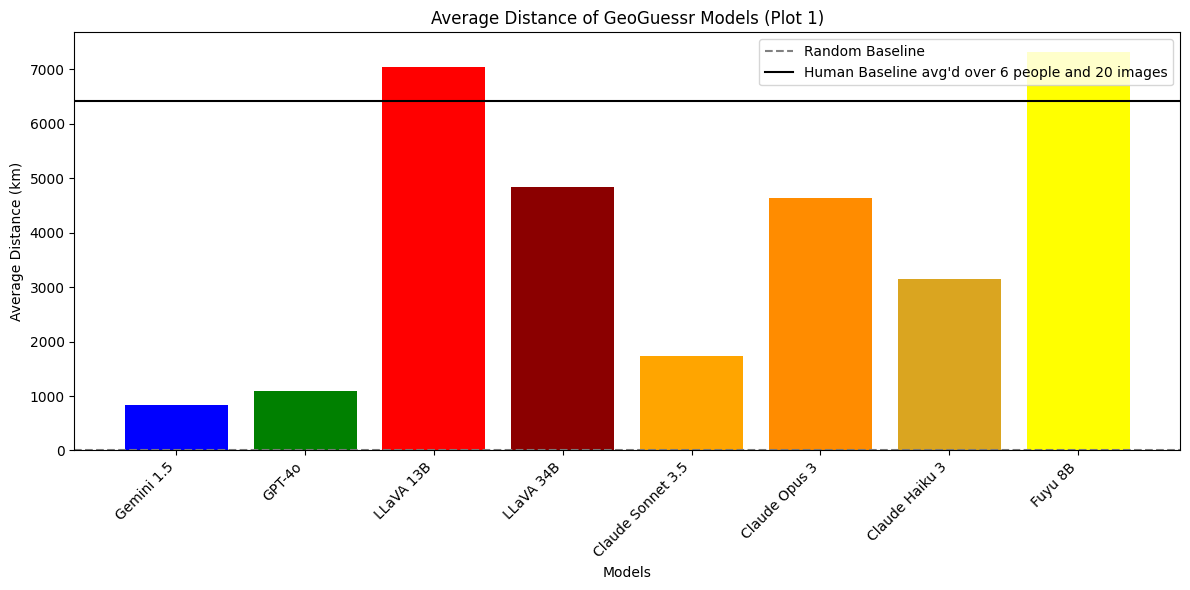

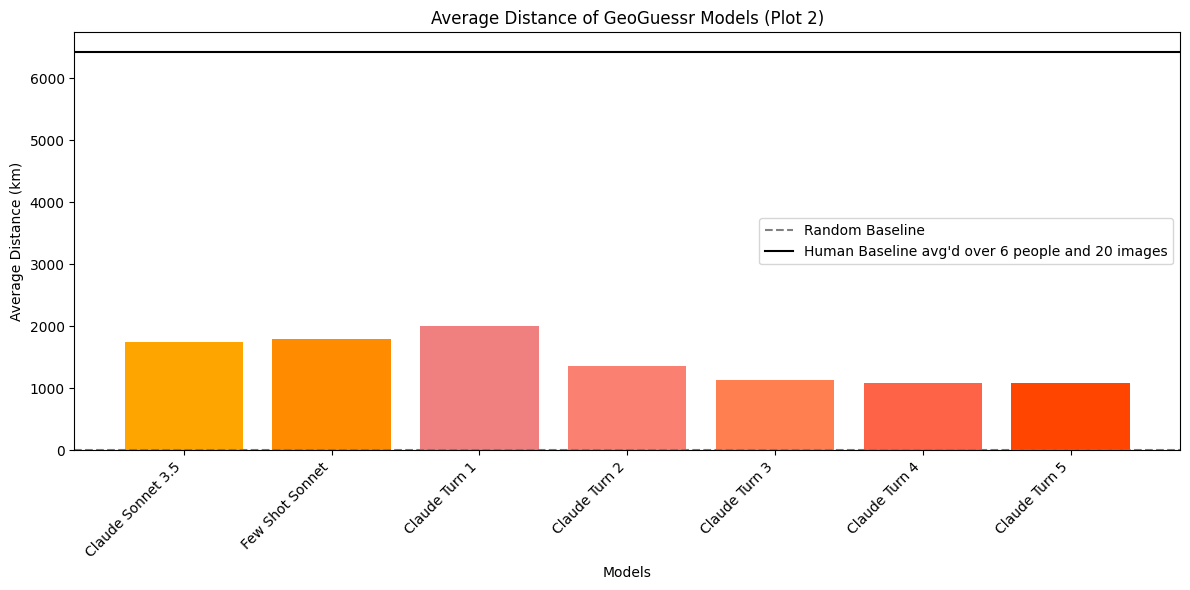

In [ ]:
# prompt: turn the plot in the cell above into two plots
# - one with just the 8 models, llava 13b and 34b have similar colours, the three claude models similar orange colour shades.
# - one plot with claude sonnet 3.5, few shot sonnet, claude turn 1 to turn 5

eyeballed_human = 6416


models_plot1 = ['Gemini 1.5', 'GPT-4o', 'LLaVA 13B', 'LLaVA 34B', 'Claude Sonnet 3.5', 'Claude Opus 3', 'Claude Haiku 3', 'Fuyu 8B']
averages_plot1 = [average_distance_gemini, average_distance_openai, average_distance_replicate, average_distance_llava34, average_distance_claude_sonnet, average_distance_claude_opus, average_distance_claude_haiku, average_distance_fuyu]
colors_plot1 = ['blue', 'green', 'red', 'darkred', 'orange', 'darkorange', 'goldenrod', 'yellow']

plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(models_plot1, averages_plot1, color=colors_plot1)
plt.axhline(y=all_random_distances, color='gray', linestyle='--', label='Random Baseline')
plt.axhline(y=eyeballed_human, color='black', linestyle='-', label='Human Baseline avg\'d over 6 people and 20 images')


plt.xlabel('Models')
plt.ylabel('Average Distance (km)')
plt.title('Average Distance of GeoGuessr Models (Plot 1)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()




models_plot2 = ['Claude Sonnet 3.5', 'Few Shot Sonnet', 'Claude Turn 1', 'Claude Turn 2', 'Claude Turn 3', 'Claude Turn 4', 'Claude Turn 5']
averages_plot2 = [average_distance_claude_sonnet, average_distance_sonnet_few, average_distance_claude_1, average_distance_claude_2, average_distance_claude_3, average_distance_claude_4, average_distance_claude_5]
colors_plot2 = ['orange', 'darkorange', 'lightcoral', 'salmon', 'coral', 'tomato', 'orangered']

plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(models_plot2, averages_plot2, color=colors_plot2)
plt.axhline(y=all_random_distances, color='gray', linestyle='--', label='Random Baseline')
plt.axhline(y=eyeballed_human, color='black', linestyle='-', label='Human Baseline avg\'d over 6 people and 20 images')


plt.xlabel('Models')
plt.ylabel('Average Distance (km)')
plt.title('Average Distance of GeoGuessr Models (Plot 2)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


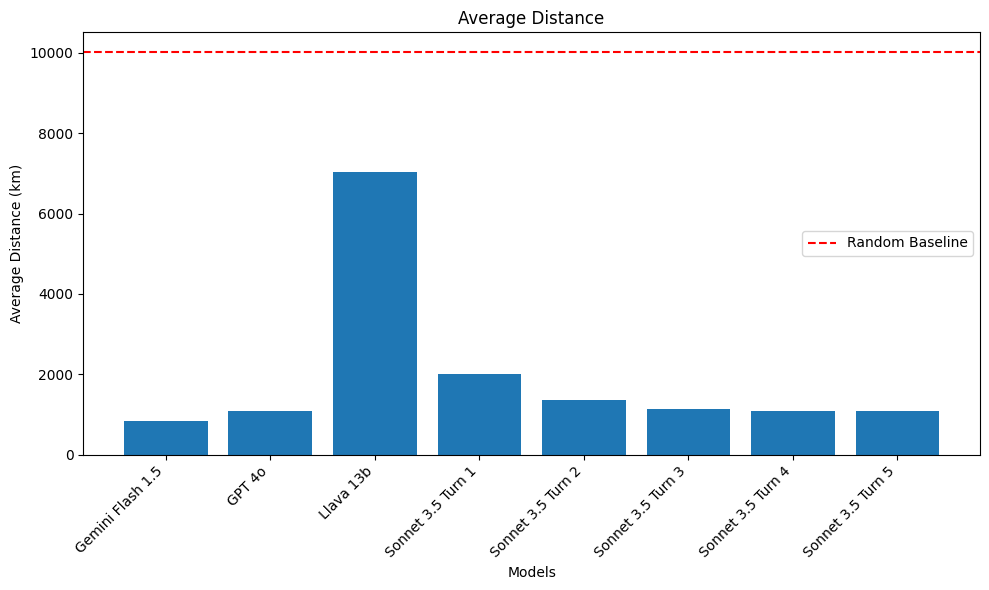

In [ ]:
# prompt: plot bars for each model and each claude turn, with a random baseline dashed line

import matplotlib.pyplot as plt

# Data for the bar chart
models = ['Gemini Flash 1.5', 'GPT 4o', 'Llava 13b', 'Sonnet 3.5 Turn 1', 'Sonnet 3.5 Turn 2', 'Sonnet 3.5 Turn 3', 'Sonnet 3.5 Turn 4', 'Sonnet 3.5 Turn 5']
average_distances = [average_distance_gemini, average_distance_openai, average_distance_replicate, average_distance_claude_1, average_distance_claude_2, average_distance_claude_3, average_distance_claude_4, average_distance_claude_5]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, average_distances)

# Add a dashed line for the random baseline
plt.axhline(y=all_random_distances, color='r', linestyle='--', label='Random Baseline')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Average Distance (km)')
plt.title('Average Distance')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Count NaN values in 'distance' column for each model
gemini_nan_count = gemini_df['distance'].isna().sum()
claude_nan_count = claude_df['distance'].isna().sum()
openai_nan_count = openai_df['distance'].isna().sum()
replicate_nan_count = replicate_df['distance'].isna().sum()

print(f"Gemini NaN count: {gemini_nan_count}")
print(f"Claude NaN count: {claude_nan_count}")
print(f"OpenAI NaN count: {openai_nan_count}")
print(f"Replicate NaN count: {replicate_nan_count}")


Gemini NaN count: 9
Claude NaN count: 0
OpenAI NaN count: 0
Replicate NaN count: 53


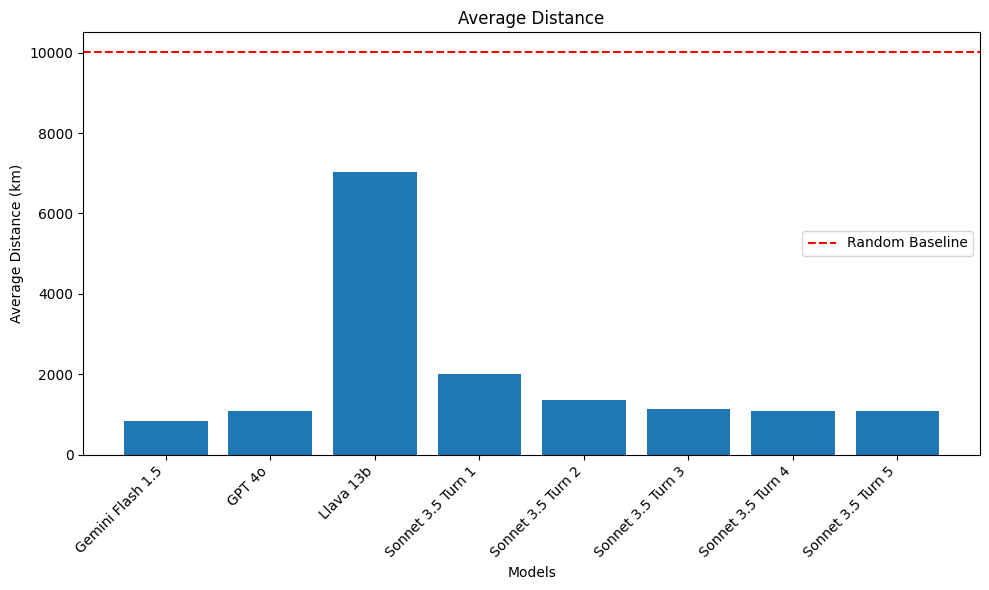

In [ ]:
# prompt: plot bars for each model and each claude turn, with a random baseline dashed line

import matplotlib.pyplot as plt

# Data for the bar chart
models = ['Gemini Flash 1.5', 'GPT 4o', 'Llava 13b', 'Sonnet 3.5 Turn 1', 'Sonnet 3.5 Turn 2', 'Sonnet 3.5 Turn 3', 'Sonnet 3.5 Turn 4', 'Sonnet 3.5 Turn 5']
average_distances = [average_distance_gemini, average_distance_openai, average_distance_replicate, average_distance_claude_1, average_distance_claude_2, average_distance_claude_3, average_distance_claude_4, average_distance_claude_5]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, average_distances)

# Add a dashed line for the random baseline
plt.axhline(y=all_random_distances, color='r', linestyle='--', label='Random Baseline')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Average Distance (km)')
plt.title('Average Distance')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# prompt: calculate the 4 moments for gemini gpt llava and sonnet, and interpret results

import numpy as np

def calculate_moments(data):
  """Calculates the first four moments of a dataset."""
  mean = np.mean(data)
  variance = np.var(data)
  skewness = np.skew(data)
  kurtosis = np.kurtosis(data)
  return mean, variance, skewness, kurtosis


# Assuming your dataframes are named gemini_df, openai_df, replicate_df, claude_df
gemini_distances = gemini_df['distance'].dropna()
openai_distances = openai_df['distance'].dropna()
llava_distances = replicate_df['distance'].dropna()  # Assuming Replicate is Llava
claude_distances = claude_df['distance'].dropna()

# Calculate the moments for each model
gemini_moments = calculate_moments(gemini_distances)
openai_moments = calculate_moments(openai_distances)
llava_moments = calculate_moments(llava_distances)
claude_moments = calculate_moments(claude_distances)

print("Gemini Moments (Mean, Variance, Skewness, Kurtosis):", gemini_moments)
print("OpenAI Moments (Mean, Variance, Skewness, Kurtosis):", openai_moments)
print("LLaVa Moments (Mean, Variance, Skewness, Kurtosis):", llava_moments)
print("Claude Moments (Mean, Variance, Skewness, Kurtosis):", claude_moments)


# Interpretation:

# Mean:
# - A lower mean indicates that the model generally predicts locations closer to the true location.

# Variance:
# - A lower variance suggests that the model's predictions are more consistent and less spread out.

# Skewness:
# - Positive skewness indicates that the distribution of errors has a longer tail on the right, meaning there are some predictions that are significantly further away than the average.
# - Negative skewness indicates the opposite, with a longer tail on the left.

# Kurtosis:
# - A higher kurtosis indicates a sharper peak and heavier tails in the distribution, which means there are more outliers.
# - A lower kurtosis suggests a flatter distribution with fewer outliers.


# Based on the results, you can analyze and compare the performance of the models in terms of their overall accuracy (mean), consistency (variance), and the presence of extreme errors (skewness, kurtosis).


AttributeError: module 'numpy' has no attribute 'skew'

In [ ]:
# prompt: AttributeError: module 'numpy' has no attribute 'skew'

import scipy.stats as stats

def calculate_moments(data):
  """Calculates the first four moments of a dataset."""
  mean = np.mean(data)
  variance = np.var(data)
  skewness = stats.skew(data)
  kurtosis = stats.kurtosis(data)
  return mean, variance, skewness, kurtosis


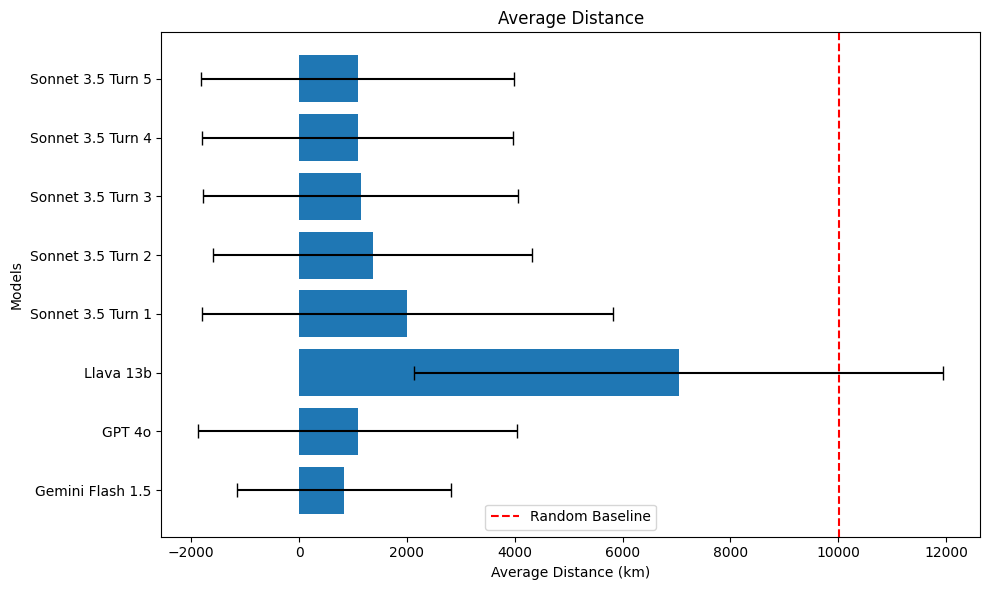

In [ ]:
# prompt: make the graph average distance above sideways instead of vertical, and also error bars for each bar

import matplotlib.pyplot as plt
import numpy as np

# ... (Your existing code to calculate average distances) ...

# Data for the bar chart
models = ['Gemini Flash 1.5', 'GPT 4o', 'Llava 13b', 'Sonnet 3.5 Turn 1', 'Sonnet 3.5 Turn 2', 'Sonnet 3.5 Turn 3', 'Sonnet 3.5 Turn 4', 'Sonnet 3.5 Turn 5']
average_distances = [average_distance_gemini, average_distance_openai, average_distance_replicate, average_distance_claude_1, average_distance_claude_2, average_distance_claude_3, average_distance_claude_4, average_distance_claude_5]

# Calculate standard deviations (replace with actual standard deviation calculations if available)
# For example, if you have a list of distances for each model, you can use np.std()
# standard_deviations = [np.std(gemini_distances), np.std(openai_distances), ...]
standard_deviations = [gemini_df['distance'].std(), openai_df['distance'].std(), replicate_df['distance'].std(), api_scaff_results['guess_1_distance'].std(), api_scaff_results['guess_2_distance'].std(), api_scaff_results['guess_3_distance'].std(), api_scaff_results['guess_4_distance'].std(), api_scaff_results['guess_5_distance'].std()]

# If standard deviations are unavailable, you can use a placeholder value (e.g., 10)
#standard_deviations = [10] * len(average_distances)


# Create the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(models, average_distances, xerr=standard_deviations, capsize=5)  # Add error bars

# Add a dashed line for the random baseline
plt.axvline(x=all_random_distances, color='r', linestyle='--', label='Random Baseline')

# Add labels and title
plt.xlabel('Average Distance (km)')
plt.ylabel('Models')
plt.title('Average Distance')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


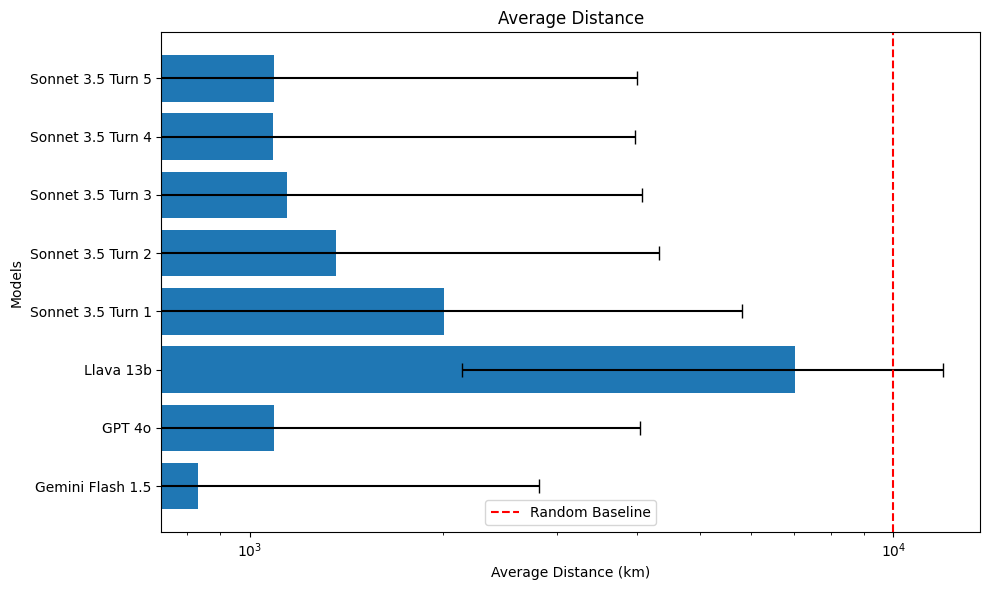

In [ ]:
# prompt: make the graph average distance above sideways instead of vertical, and also error bars for each bar

import matplotlib.pyplot as plt
import numpy as np

# ... (Your existing code to calculate average distances) ...

# Data for the bar chart
models = ['Gemini Flash 1.5', 'GPT 4o', 'Llava 13b', 'Sonnet 3.5 Turn 1', 'Sonnet 3.5 Turn 2', 'Sonnet 3.5 Turn 3', 'Sonnet 3.5 Turn 4', 'Sonnet 3.5 Turn 5']
average_distances = [average_distance_gemini, average_distance_openai, average_distance_replicate, average_distance_claude_1, average_distance_claude_2, average_distance_claude_3, average_distance_claude_4, average_distance_claude_5]

# Calculate standard deviations (replace with actual standard deviation calculations if available)
# For example, if you have a list of distances for each model, you can use np.std()
# standard_deviations = [np.std(gemini_distances), np.std(openai_distances), ...]
standard_deviations = [gemini_df['distance'].std(), openai_df['distance'].std(), replicate_df['distance'].std(), api_scaff_results['guess_1_distance'].std(), api_scaff_results['guess_2_distance'].std(), api_scaff_results['guess_3_distance'].std(), api_scaff_results['guess_4_distance'].std(), api_scaff_results['guess_5_distance'].std()]

# If standard deviations are unavailable, you can use a placeholder value (e.g., 10)
#standard_deviations = [10] * len(average_distances)


# Create the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(models, average_distances, xerr=standard_deviations, capsize=5)  # Add error bars

# Add a dashed line for the random baseline
plt.axvline(x=all_random_distances, color='r', linestyle='--', label='Random Baseline')

# Add labels and title
plt.xlabel('Average Distance (km)')
plt.xscale('log')
plt.ylabel('Models')
plt.title('Average Distance')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


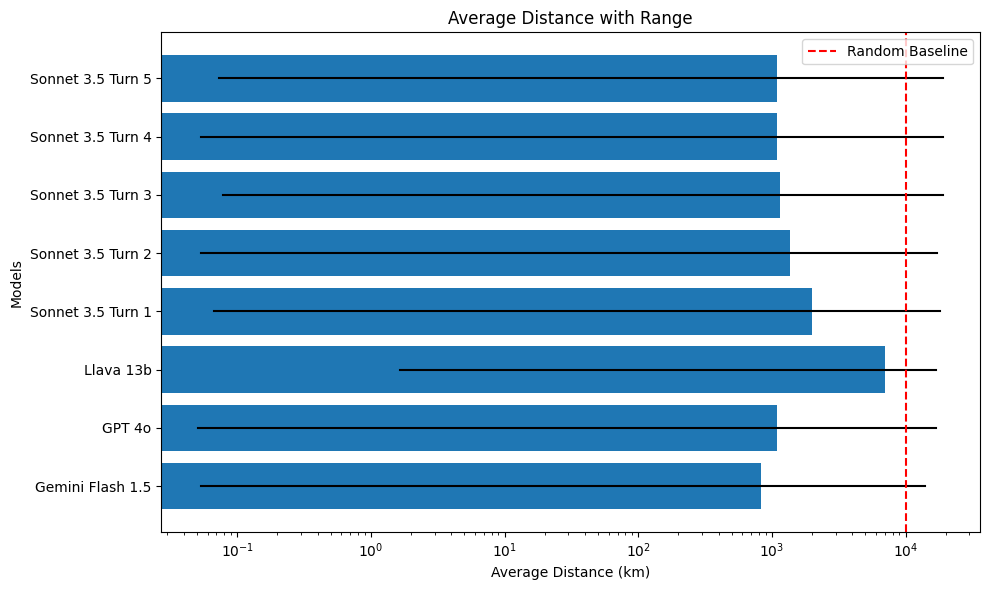

In [ ]:
# prompt: make the graph average distance above sideways instead of vertical, and also calculate range min to max distance and plot mix-max range bars for each bar

# ... (Your existing code to calculate average distances and standard deviations) ...

# Data for the horizontal bar chart
models = ['Gemini Flash 1.5', 'GPT 4o', 'Llava 13b', 'Sonnet 3.5 Turn 1', 'Sonnet 3.5 Turn 2', 'Sonnet 3.5 Turn 3', 'Sonnet 3.5 Turn 4', 'Sonnet 3.5 Turn 5']
average_distances = [average_distance_gemini, average_distance_openai, average_distance_replicate, average_distance_claude_1, average_distance_claude_2, average_distance_claude_3, average_distance_claude_4, average_distance_claude_5]
# Calculate min and max distances for each model (replace with your actual data)
min_distances = [
    gemini_df['distance'].min(),
    openai_df['distance'].min(),
    replicate_df['distance'].min(),
    api_scaff_results['guess_1_distance'].min(),
    api_scaff_results['guess_2_distance'].min(),
    api_scaff_results['guess_3_distance'].min(),
    api_scaff_results['guess_4_distance'].min(),
    api_scaff_results['guess_5_distance'].min()
]
max_distances = [
    gemini_df['distance'].max(),
    openai_df['distance'].max(),
    replicate_df['distance'].max(),
    api_scaff_results['guess_1_distance'].max(),
    api_scaff_results['guess_2_distance'].max(),
    api_scaff_results['guess_3_distance'].max(),
    api_scaff_results['guess_4_distance'].max(),
    api_scaff_results['guess_5_distance'].max()
]


# Create the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(models, average_distances)


# Add error bars representing the range of distances (min to max)
for i, model in enumerate(models):
    plt.plot([min_distances[i], max_distances[i]], [i, i], color='black')

# Add a dashed line for the random baseline
plt.axvline(x=all_random_distances, color='r', linestyle='--', label='Random Baseline')

# Add labels and title
plt.xlabel('Average Distance (km)')
plt.xscale('log')
plt.ylabel('Models')
plt.title('Average Distance with Range')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


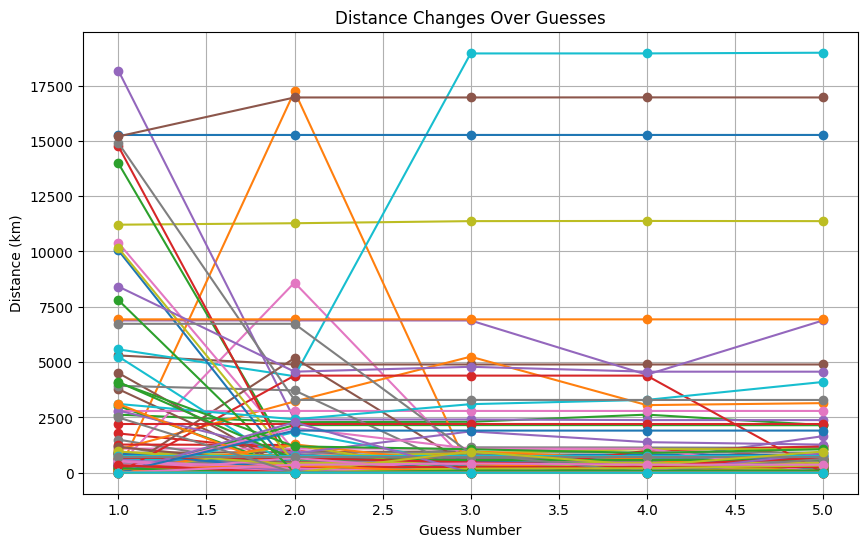

In [ ]:
# prompt: good, now replace the lines with the distance changes lines from all_results

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Iterate through the all_results and plot the distance changes
for results in all_results:
  distances = [float(results[f'guess_{i+1}_distance']) for i in range(5) if results.get(f'guess_{i+1}_distance') and results[f'guess_{i+1}_distance'] != 'N/A']
  if distances:
    plt.plot(range(1, len(distances) + 1), distances, marker='o', label=results['filename'])

# Add labels and title
plt.xlabel('Guess Number')
plt.ylabel('Distance (km)')
plt.title('Distance Changes Over Guesses')

# Add a legend
# plt.legend(loc='upper right', fontsize='small')  # Adjust legend location as needed

# Show the plot
plt.grid(True)
plt.show()


In [ ]:
# prompt: subtract distances[0] from distances

distances = [float(results[f'guess_{i+1}_distance']) for i in range(5) if results.get(f'guess_{i+1}_distance') and results[f'guess_{i+1}_distance'] != 'N/A']
if distances:
  initial_distance = distances[0]
  distances_diff = [distance - initial_distance for distance in distances]
  plt.plot(range(1, len(distances_diff) + 1), distances_diff, marker='o', label=results['filename'])


TypeError: unsupported operand type(s) for -: 'list' and 'float'

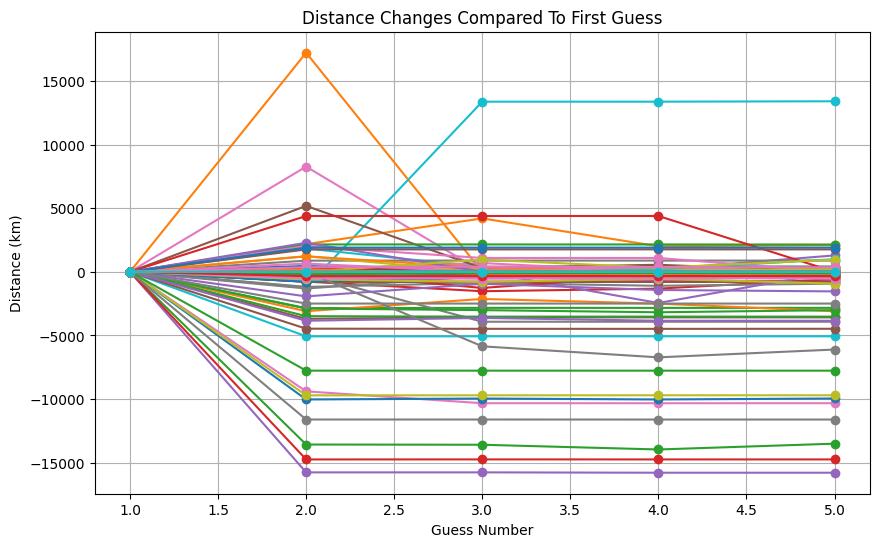

In [ ]:
# prompt: good, now replace the lines with the distance changes lines from all_results

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Iterate through the all_results and plot the distance changes
for results in all_results:
  distances = [float(results[f'guess_{i+1}_distance']) for i in range(5) if results.get(f'guess_{i+1}_distance') and results[f'guess_{i+1}_distance'] != 'N/A']

  if distances:
    initial_distance = distances[0]
    distances_diff = [distance - initial_distance for distance in distances]
    plt.plot(range(1, len(distances_diff) + 1), distances_diff, marker='o', label=results['filename'])

# Add labels and title
plt.xlabel('Guess Number')
plt.ylabel('Distance (km)')
plt.title('Distance Changes Compared To First Guess')

# Add a legend
# plt.legend(loc='upper right', fontsize='small')  # Adjust legend location as needed

# Show the plot
plt.grid(True)
plt.show()


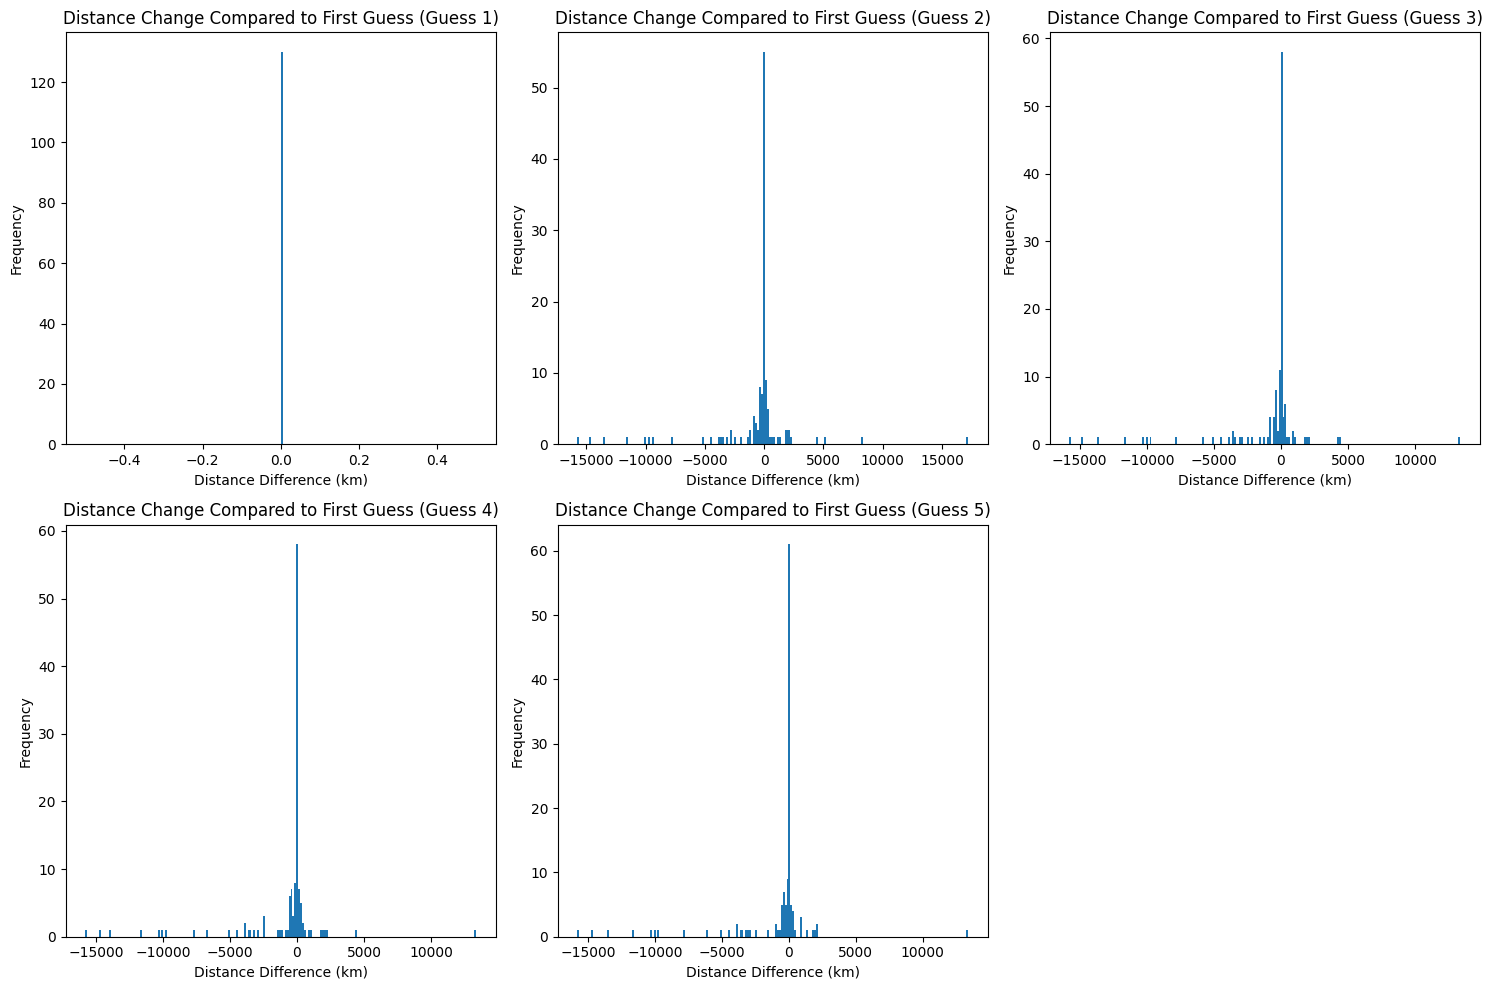

In [ ]:
# prompt: plot out distance changes compared to first guess for all 5 guess numbers (so 5 bar plots)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for guess_num in range(1, 6):
  plt.subplot(2, 3, guess_num)
  distances_diff_list = []
  for results in all_results:
    distances = [float(results[f'guess_{i+1}_distance']) for i in range(5) if results.get(f'guess_{i+1}_distance') and results[f'guess_{i+1}_distance'] != 'N/A']
    if distances:
      initial_distance = distances[0]
      if guess_num <= len(distances):
        distances_diff = distances[guess_num - 1] - initial_distance
        distances_diff_list.append(distances_diff)

  plt.hist(distances_diff_list, bins=200)
  plt.title(f'Distance Change Compared to First Guess (Guess {guess_num})')
  plt.xlabel('Distance Difference (km)')
  plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


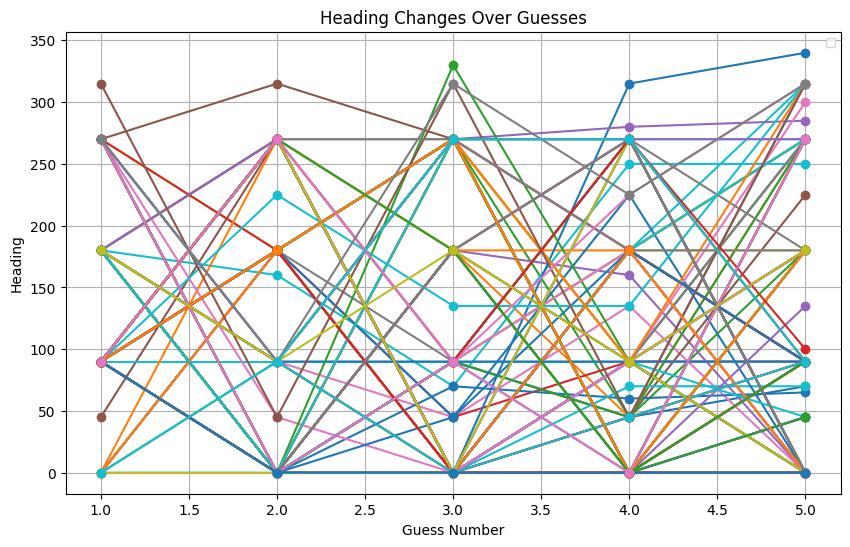

In [ ]:
# prompt: same as above but for headings

plt.figure(figsize=(10, 6))  # Adjust figure size as needed


# Iterate through the all_results and plot the heading changes
for results in all_results:
  headings = [float(results[f'guess_{i+1}_heading']) for i in range(5) if results[f'guess_{i+1}_heading'] != 'N/A']
  if headings:
    plt.plot(range(1, len(headings) + 1), headings, marker='o')
#    plt.plot(range(1, len(headings) + 1), headings, marker='o', label=results['filename'])


# Add labels and title
plt.xlabel('Guess Number')
plt.ylabel('Heading')
plt.title('Heading Changes Over Guesses')


# Add a legend
plt.legend(loc='upper right', fontsize='small')  # Adjust legend location as needed


# Show the plot
plt.grid(True)
plt.show()


In [ ]:
# prompt: plot out distance changes compared to first guess for all 5 guess numbers (so 5 bar plots)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for guess_num in range(1, 6):
  plt.subplot(2, 3, guess_num)
  distances_diff_list = []
  for results in all_results:
    distances = [float(results[f'guess_{i+1}_distance']) for i in range(5) if results.get(f'guess_{i+1}_distance') and results[f'guess_{i+1}_distance'] != 'N/A']
    if distances:
      initial_distance = distances[0]
      if guess_num <= len(distances):
        distances_diff = distances[guess_num - 1] - initial_distance
        distances_diff_list.append(distances_diff)

  plt.hist(distances_diff_list, bins=200)
  plt.title(f'Distance Change Compared to First Guess (Guess {guess_num})')
  plt.xlabel('Distance Difference (km)')
  plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


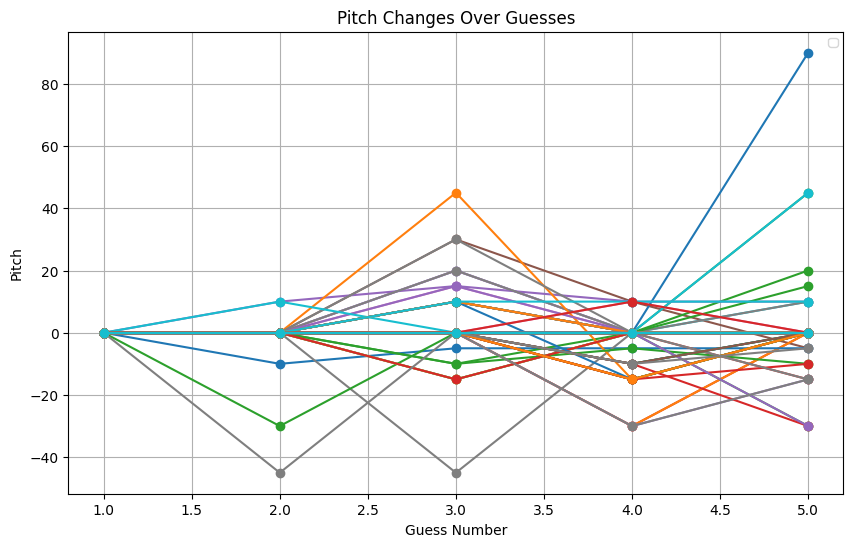

In [ ]:
# prompt: same above but for pitch

plt.figure(figsize=(10, 6))  # Adjust figure size as needed


# Iterate through the all_results and plot the pitch changes
for results in all_results:
  pitchs = [float(results[f'guess_{i+1}_pitch']) for i in range(5) if results[f'guess_{i+1}_pitch'] != 'N/A']
  if pitchs:
    plt.plot(range(1, len(pitchs) + 1), pitchs, marker='o')
#    plt.plot(range(1, len(pitchs) + 1), pitchs, marker='o', label=results['filename'])


# Add labels and title
plt.xlabel('Guess Number')
plt.ylabel('Pitch')
plt.title('Pitch Changes Over Guesses')


# Add a legend
plt.legend(loc='upper right', fontsize='small')  # Adjust legend location as needed


# Show the plot
plt.grid(True)
plt.show()


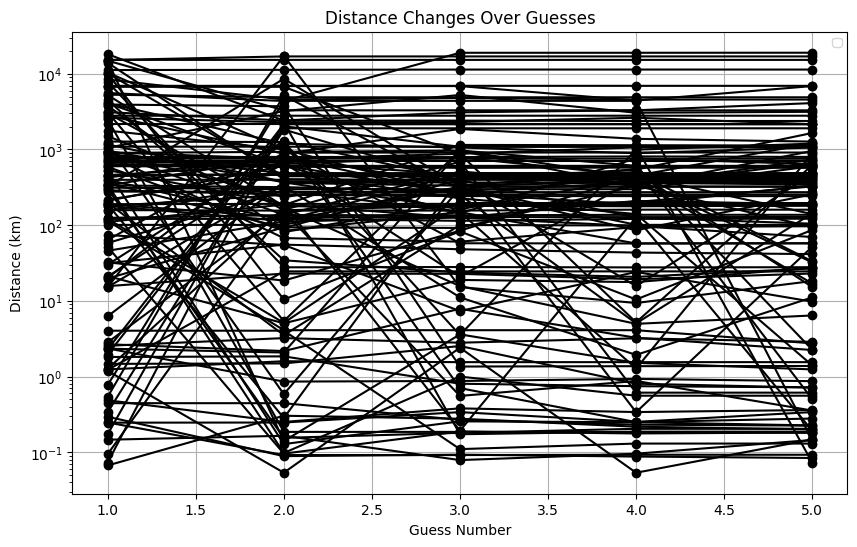

In [ ]:
# prompt: set y scale of the above to log distance, and make same colour

# ... (Your existing code) ...

plt.figure(figsize=(10, 6))  # Adjust figure size as needed


# Iterate through the all_results and plot the distance changes
for results in all_results:
  distances = [results[f'guess_{i+1}_distance'] for i in range(5) if results[f'guess_{i+1}_distance'] != 'N/A']
  if distances:
    plt.plot(range(1, len(distances) + 1), distances, marker='o', color='black') # Set color to blue


# Add labels and title
plt.xlabel('Guess Number')
plt.ylabel('Distance (km)')
plt.title('Distance Changes Over Guesses')

plt.yscale('log') # Set y-scale to logarithmic

# Add a legend
plt.legend(loc='upper right', fontsize='small')  # Adjust legend location as needed


# Show the plot
plt.grid(True)
plt.show()

# ... (Rest of your code) ...


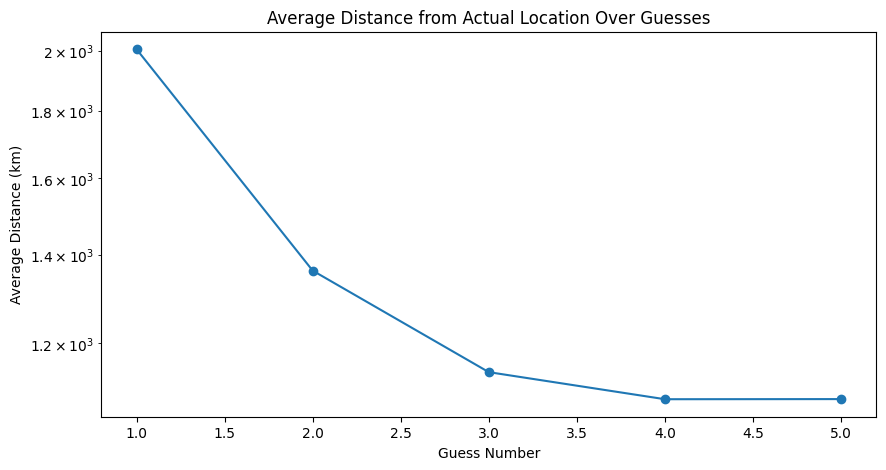

In [ ]:
# prompt: draw plots for distance change like the cell right above, but averaged out

import pandas as pd
import matplotlib.pyplot as plt

# Assuming your CSV file is named 'api_scaff_results.csv' and in the 'claude_test' folder
df = pd.read_csv('/content/claude_test/api_scaff_results.csv')

# Calculate the average distance for each guess number
average_distances = []
for i in range(1, 6):
    distances = [
        float(row[f'guess_{i}_distance'])
        for _, row in df.iterrows()
        if row[f'guess_{i}_distance'] != 'N/A'
    ]
    if distances:
        average_distances.append(sum(distances) / len(distances))
    else:
        average_distances.append(None)

# Plot the average distances
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), average_distances, marker='o')
plt.title("Average Distance from Actual Location Over Guesses")
plt.xlabel("Guess Number")
plt.ylabel("Average Distance (km)")
plt.yscale()
plt.show()


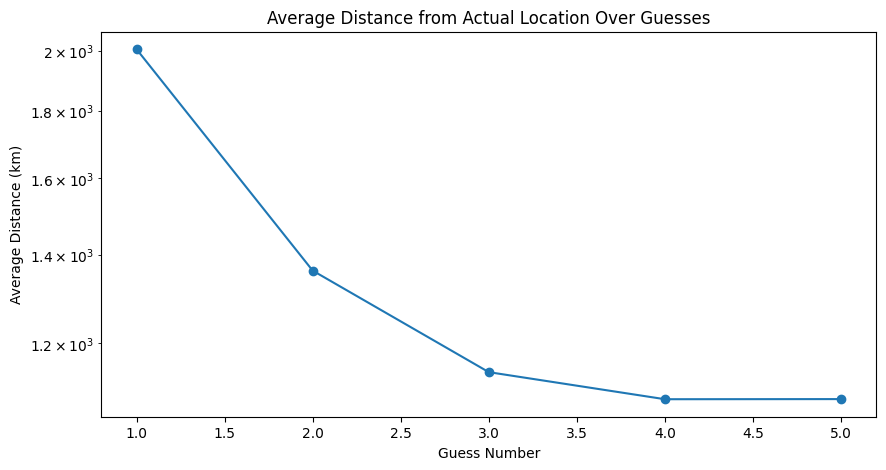

In [ ]:
# prompt: copy the same as cell above, but average distance is log, like ax.hist(distances, bins=np.logspace(-2, 5, 10)). USE THE NP LOGSCALE MUST

# Assuming your CSV file is named 'api_scaff_results.csv' and in the 'claude_test' folder
df = pd.read_csv('/content/api_scaff_results.csv')

# Calculate the average distance for each guess number
average_distances = []
for i in range(1, 6):
    distances = [
        float(row[f'guess_{i}_distance'])
        for _, row in df.iterrows()
        if row[f'guess_{i}_distance'] != 'N/A'
    ]
    if distances:
        average_distances.append(sum(distances) / len(distances))
    else:
        average_distances.append(None)

# Plot the average distances with log scale
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), average_distances, marker='o')
plt.title("Average Distance from Actual Location Over Guesses")
plt.xlabel("Guess Number")
plt.ylabel("Average Distance (km)")
plt.yscale('log') # Set y-scale to logarithmic
plt.show()



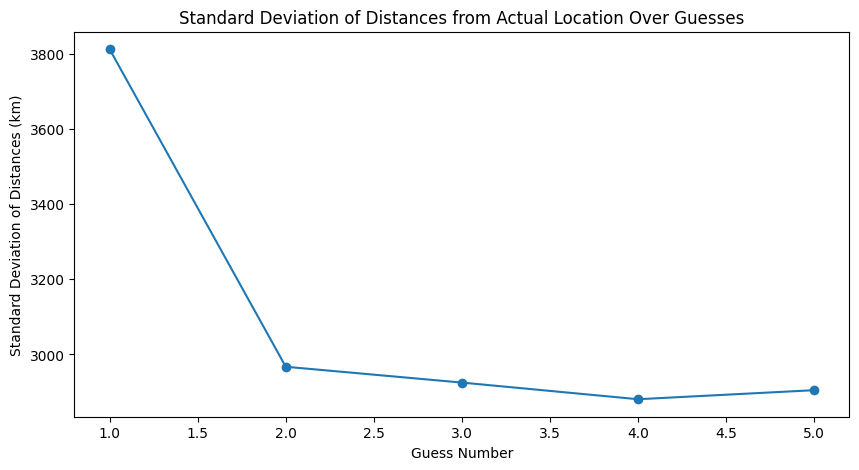

In [ ]:
# prompt: get deviation of distances for each turn

# Assuming your CSV file is named 'api_scaff_results.csv' and in the 'claude_test' folder
df = pd.read_csv('/content/claude_test/api_scaff_results.csv')

# Calculate the standard deviation of distances for each guess number
deviation_distances = []
for i in range(1, 6):
    distances = [
        float(row[f'guess_{i}_distance'])
        for _, row in df.iterrows()
        if row[f'guess_{i}_distance'] != 'N/A'
    ]
    if distances:
        deviation_distances.append(pd.Series(distances).std())
    else:
        deviation_distances.append(None)

# Plot the standard deviation of distances
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), deviation_distances, marker='o')
plt.title("Standard Deviation of Distances from Actual Location Over Guesses")
plt.xlabel("Guess Number")
plt.ylabel("Standard Deviation of Distances (km)")
plt.show()




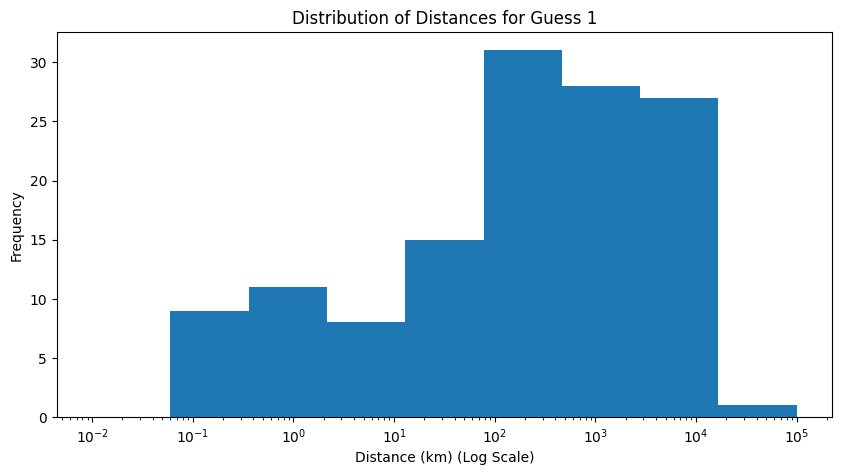

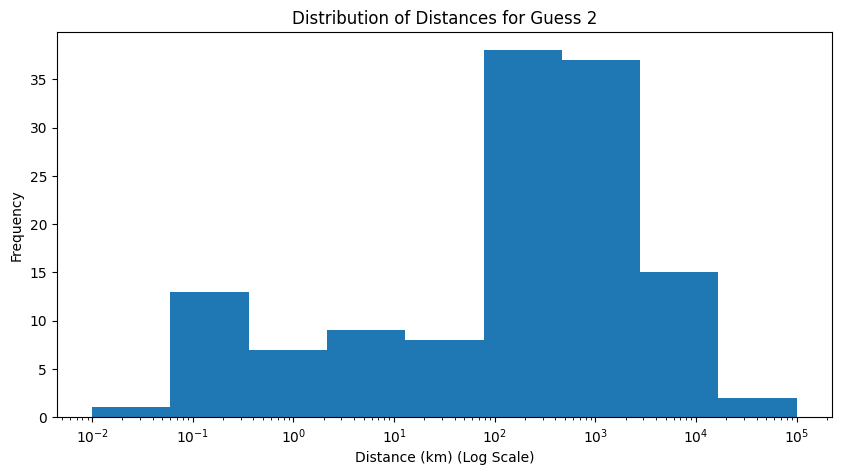

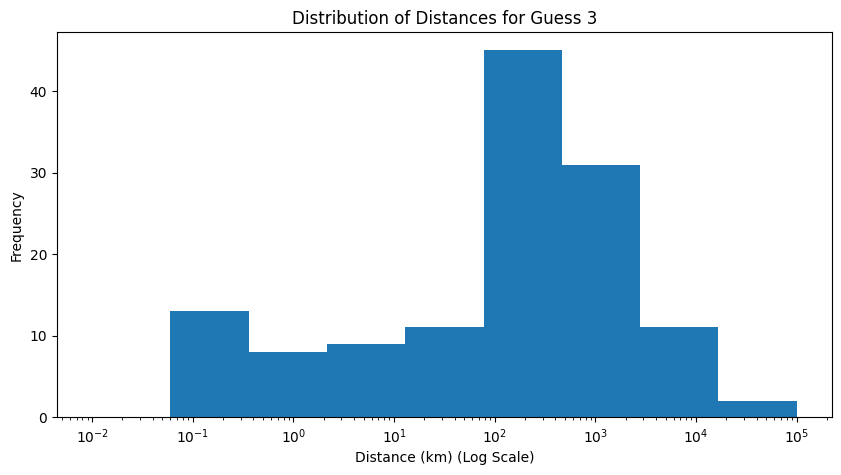

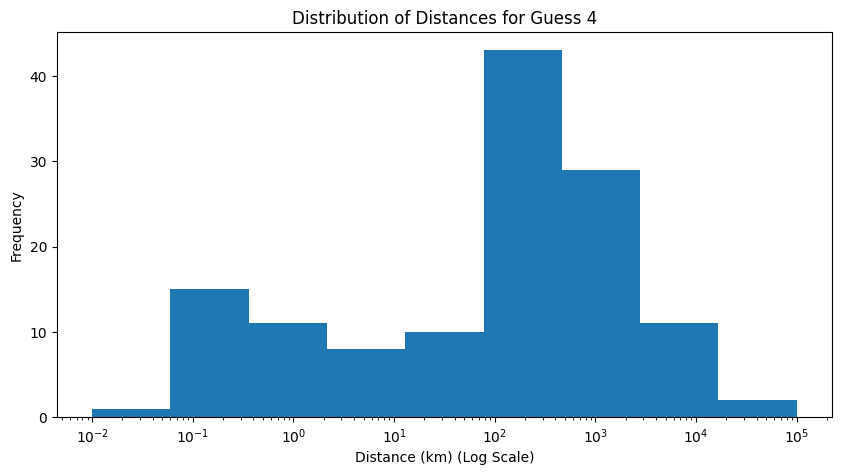

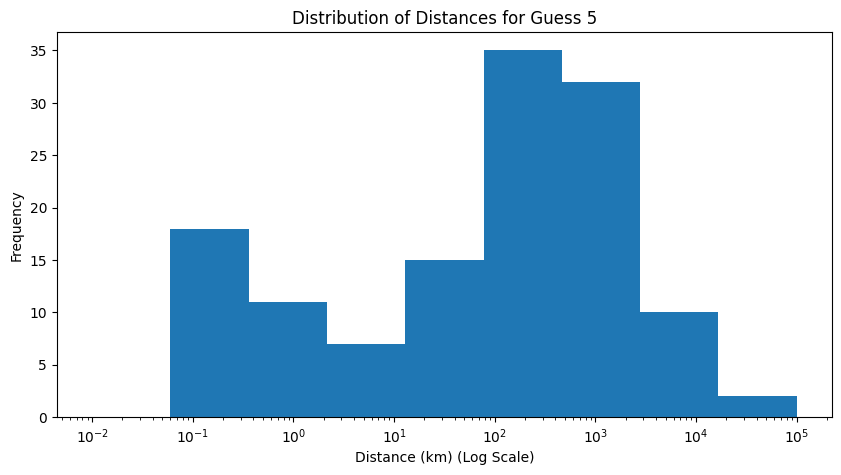

In [ ]:
# prompt: log scale distance graphs from each guess number, each with its own bar plot, log distance x axis, frequency on y axis,

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming your CSV file is named 'api_scaff_results.csv' and in the 'claude_test' folder
df = pd.read_csv('/content/claude_test/api_scaff_results.csv')

# Iterate through guess numbers
for i in range(1, 6):
  distances = [
      float(row[f'guess_{i}_distance'])
      for _, row in df.iterrows()
      if row[f'guess_{i}_distance'] != 'N/A'
  ]
  if distances:
    plt.figure(figsize=(10, 5))
    plt.hist(distances, bins=np.logspace(-2, 5, 10))
    plt.xscale('log')
    plt.xlabel('Distance (km) (Log Scale)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Distances for Guess {i}')
    plt.show()


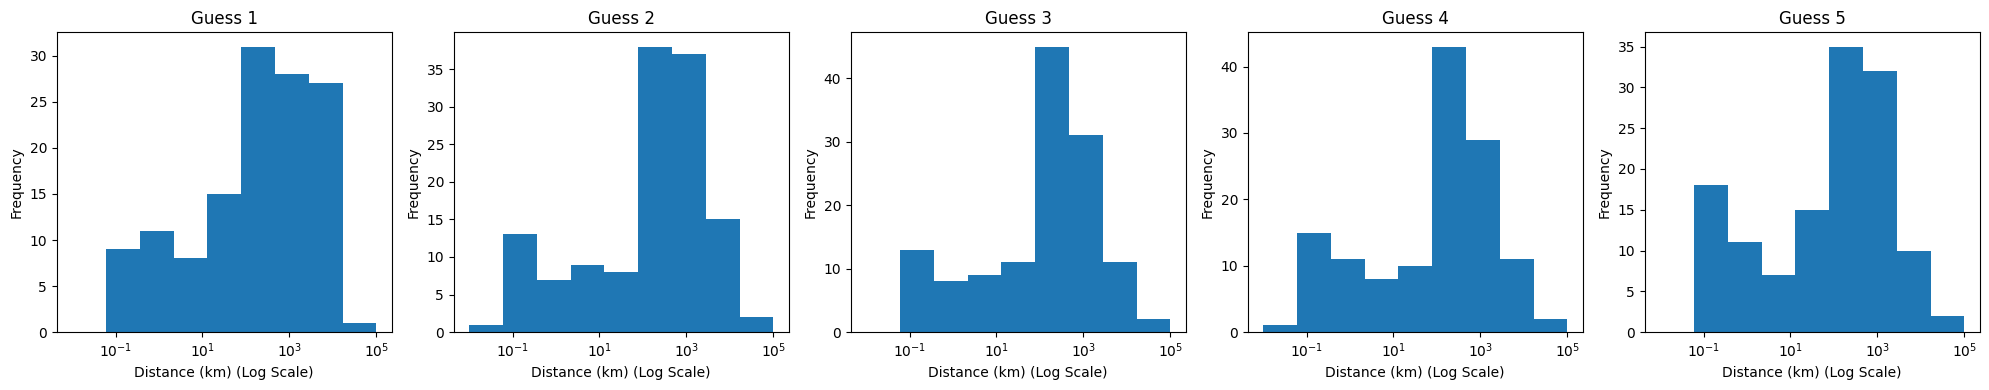

In [ ]:
# prompt: make all the graphs of frequency and distance log scales from 5 guess turns above into one saved png

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming your CSV file is named 'api_scaff_results.csv' and in the 'claude_test' folder
df = pd.read_csv('/content/claude_test/api_scaff_results.csv')

# Create a figure with subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Adjust figsize as needed

# Iterate through guess numbers and create histograms
for i, ax in enumerate(axs):
    guess_num = i + 1
    distances = [
        float(row[f'guess_{guess_num}_distance'])
        for _, row in df.iterrows()
        if row[f'guess_{guess_num}_distance'] != 'N/A'
    ]
    if distances:
        ax.hist(distances, bins=np.logspace(-2, 5, 10))
        ax.set_xscale('log')
        ax.set_xlabel('Distance (km) (Log Scale)')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Guess {guess_num}')
    else:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
        ax.set_title(f'Guess {guess_num}')

# Adjust spacing between subplots
plt.tight_layout()

# Save the figure
plt.savefig('/content/claude_test/combined_distance_histograms.png')

# Show the figure (optional)
plt.show()


In [ ]:
!pip install folium

In [ ]:
import folium

In [ ]:
def calculate_bearing(lon1, lat1, lon2, lat2):
    """Calculates the bearing between two points using their longitude and latitude.

    Args:
        lon1: Longitude of the first point.
        lat1: Latitude of the first point.
        lon2: Longitude of the second point.
        lat2: Latitude of the second point.

    Returns:
        The bearing (in degrees) from the first point to the second point.
    """
    lat1_rad = math.radians(lat1)
    lat2_rad = math.radians(lat2)
    lon_diff_rad = math.radians(lon2 - lon1)

    y = math.sin(lon_diff_rad) * math.cos(lat2_rad)
    x = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(lon_diff_rad)

    bearing_rad = math.atan2(y, x)
    bearing_deg = math.degrees(bearing_rad)

    # Normalize to 0-360 degrees
    bearing_deg = (bearing_deg + 360) % 360

    return bearing_deg

# Assuming your CSV file is named 'api_scaff_results.csv' and in the 'claude_test' folder
df = pd.read_csv('/content/api_scaff_results.csv')

# Create a map centered at a specific location (e.g., 0,0)
m = folium.Map(location=[0, 0], zoom_start=2)

# Select a specific row (e.g., the first row)
row = df.iloc[107]  # Change the index to select a different row


# Extract latitude and longitude values for each guess
lat_values = []
lng_values = []
for i in range(1, 6):
    if row[f'guess_{i}_lat'] != 'N/A':
        lat_values.append(float(row[f'guess_{i}_lat']))
        lng_values.append(float(row[f'guess_{i}_lng']))

# Extract label latitude and longitude
label_lat = float(row['label_lat'])
label_lng = float(row['label_lng'])


# Create a list of coordinates
coordinates = list(zip(lat_values, lng_values))

# Add markers and lines for each coordinate
if coordinates:
    for i in range(len(coordinates)):
        folium.CircleMarker(
            location=coordinates[i],
            radius=5,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=1
        ).add_to(m)

        # Add text label
        folium.Marker(
            location=coordinates[i],
            icon=folium.DivIcon(html=f'<div style="font-weight: bold; font-size: 12px;">{i+1}</div>')
        ).add_to(m)


        if i < len(coordinates) - 1:
            folium.PolyLine(
                locations=[coordinates[i], coordinates[i + 1]],
                color='red',
                weight=2
            ).add_to(m)



# Add a larger circle for the label location
folium.CircleMarker(
    location=[label_lat, label_lng],
    radius=10,  # Adjust radius as needed
    color='blue',  # Change color as needed
    fill=True,
    fill_color='blue',
    fill_opacity=0.7
).add_to(m)

# Display the map
display(m)


In [ ]:
# prompt: get all label lats and label lngs, and put all as points on world map, and all final guess lats and lngs, and put different colours circles, with lines from final guess to its correct label point

import folium
import pandas as pd

# Assuming your CSV file is named 'api_scaff_results.csv' and in the 'claude_test' folder
df = pd.read_csv('/content/claude_test/api_scaff_results.csv')

# Create a map centered at a specific location (e.g., 0,0)
m = folium.Map(location=[0, 0], zoom_start=2)

# Iterate through rows in the DataFrame
for _, row in df.iterrows():
    # Extract label latitude and longitude
    label_lat = float(row['label_lat'])
    label_lng = float(row['label_lng'])

    # Extract final guess latitude and longitude (guess_5)
    if row['guess_5_lat'] != 'N/A':
        guess_lat = float(row['guess_5_lat'])
        guess_lng = float(row['guess_5_lng'])

        # Add a marker for the label location
        folium.CircleMarker(
            location=[label_lat, label_lng],
            radius=5,
            color='blue',  # Color for label locations
            fill=True,
            fill_color='blue',
            fill_opacity=0.7
        ).add_to(m)

        # Add a marker for the final guess location
        folium.CircleMarker(
            location=[guess_lat, guess_lng],
            radius=5,
            color='red',  # Color for final guess locations
            fill=True,
            fill_color='red',
            fill_opacity=0.7
        ).add_to(m)

        # Draw a line between the final guess and its correct label
        folium.PolyLine(
            locations=[[guess_lat, guess_lng], [label_lat, label_lng]],
            color='green',  # Color for the lines
            weight=1,
            opacity=0.7
        ).add_to(m)

# Display the map
display(m)


In [ ]:
openai_df.head()

image_name                                     model_response  \
0  imgs_v2/0.jpg  To determine the location depicted in the imag...   
1  imgs_v2/1.jpg  To determine the location depicted in the imag...   
2  imgs_v2/2.jpg  To determine the location depicted in the imag...   
3  imgs_v2/3.jpg  To determine the location depicted in the imag...   
4  imgs_v2/4.jpg  To determine the location depicted in the imag...   

   label_lat  label_long  predicted_lat  predicted_long predicted_city  \
0 -11.107172  -77.603894       -12.0464        -77.0428           Lima   
1 -22.411890  -47.561900       -22.0074        -47.8977         Araras   
2 -36.801640  174.748180       -37.8136        144.9631      Melbourne   
3  45.416783   11.867655        45.4064         11.8768          Padua   
4 -41.290397  174.777362       -43.5321        172.6362   Christchurch   

  predicted_country     distance  
0              Peru   121.007959  
1            Brazil    56.727027  
2         Australia  2625.547916  
3             Italy     1.357404  
4       New Zealand   304.989040

In [ ]:
# prompt: get all label lats and label lngs, and put all as points on world map, and all final guess lats and lngs, and put different colours circles, with lines from final guess to its correct label point

import folium
import pandas as pd

# Assuming your CSV file is named 'api_scaff_results.csv' and in the 'claude_test' folder
df = pd.read_csv('/content/openai_predictions.csv')

# Create a map centered at a specific location (e.g., 0,0)
m = folium.Map(location=[0, 0], zoom_start=2)

# Iterate through rows in the DataFrame
for _, row in df.iterrows():
    # Extract label latitude and longitude
    label_lat = float(row['label_lat'])
    label_lng = float(row['label_long'])

    # Extract final guess latitude and longitude (guess_5)
    if row['predicted_lat'] != 'N/A':
        guess_lat = float(row['predicted_lat'])
        guess_lng = float(row['predicted_long'])

        # Add a marker for the label location
        folium.CircleMarker(
            location=[label_lat, label_lng],
            radius=5,
            color='blue',  # Color for label locations
            fill=True,
            fill_color='blue',
            fill_opacity=0.7
        ).add_to(m)

        # Add a marker for the final guess location
        folium.CircleMarker(
            location=[guess_lat, guess_lng],
            radius=5,
            color='red',  # Color for final guess locations
            fill=True,
            fill_color='red',
            fill_opacity=0.7
        ).add_to(m)

        # Draw a line between the final guess and its correct label
        folium.PolyLine(
            locations=[[guess_lat, guess_lng], [label_lat, label_lng]],
            color='green',  # Color for the lines
            weight=1,
            opacity=0.7
        ).add_to(m)

# Display the map
display(m)


In [ ]:
# prompt: folium map above but remove cases of NaN in csv

# Assuming your CSV file is named 'api_scaff_results.csv' and in the 'claude_test' folder
df = pd.read_csv('/content/gemini_predictions.csv')

# Create a map centered at a specific location (e.g., 0,0)
m = folium.Map(location=[0, 0], zoom_start=2)

# Iterate through rows in the DataFrame
for _, row in df.iterrows():
    # Extract label latitude and longitude
    if pd.notna(row['label_lat']) and pd.notna(row['label_long']):
        label_lat = float(row['label_lat'])
        label_lng = float(row['label_long'])

        # Extract final guess latitude and longitude (guess_5)
        if pd.notna(row['predicted_lat']) and pd.notna(row['predicted_long']):
            guess_lat = float(row['predicted_lat'])
            guess_lng = float(row['predicted_long'])

            # Add a marker for the label location
            folium.CircleMarker(
                location=[label_lat, label_lng],
                radius=5,
                color='blue',  # Color for label locations
                fill=True,
                fill_color='blue',
                fill_opacity=0.7
            ).add_to(m)

            # Add a marker for the final guess location
            folium.CircleMarker(
                location=[guess_lat, guess_lng],
                radius=5,
                color='red',  # Color for final guess locations
                fill=True,
                fill_color='red',
                fill_opacity=0.7
            ).add_to(m)

            # Draw a line between the final guess and its correct label
            folium.PolyLine(
                locations=[[guess_lat, guess_lng], [label_lat, label_lng]],
                color='green',  # Color for the lines
                weight=1,
                opacity=0.7
            ).add_to(m)

# Display the map
display(m)


In [ ]:
# prompt: /content/CityCountryContinent.xlsx to csv and head

import pandas as pd


# Convert the DataFrame to a CSV file
df.to_csv('/content/sampled_cities_v2.csv', index=False)

# Display the first few rows of the DataFrame
print(df.head())


             city      city_ascii      lat       lng    country iso2 iso3  \
0          Huacho          Huacho -11.1067  -77.6050       Peru   PE  PER   
1            Soio            Soio  -6.1333   12.3667     Angola   AO  AGO   
2       Rio Claro       Rio Claro -22.4108  -47.5608     Brazil   BR  BRA   
3         Tarakan         Tarakan   3.3000  117.6333  Indonesia   ID  IDN   
4  Mandi Burewala  Mandi Burewala  30.1592   72.6817   Pakistan   PK  PAK   

         admin_name capital  population          id      Continent  \
0              Lima   admin    200585.0  1604316784  South America   
1             Zaire     NaN    200920.0  1024903782         Africa   
2         São Paulo     NaN    201418.0  1076411428  South America   
3  Kalimantan Utara     NaN    201635.0  1360080072           Asia   
4            Punjab     NaN    203454.0  1586997587           Asia   

  population_group  
0     medium_urban  
1     medium_urban  
2     medium_urban  
3     medium_urban  
4     mediu

In [ ]:
# prompt: grab 1500 random lat longs set from the sampled cities csv above and display as red circles on folium map

import pandas as pd
import folium
import random

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('/content/sampled_cities_v2.csv')

# Select 1500 random rows from the DataFrame
random_rows = df.sample(n=1500, random_state=42)  # Set a random_state for reproducibility

# Create a map centered at a specific location (e.g., 0,0)
m = folium.Map(location=[0, 0], zoom_start=2)

# Add markers for each random row
for _, row in random_rows.iterrows():
    lat = row['label_lat']
    lng = row['label_lng']
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7
    ).add_to(m)

# Display the map
display(m)


ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
# prompt: zip and download /content/claude_test

from google.colab import files
!zip -r /content/claude_test.zip /content/claude_test
files.download('/content/claude_test.zip')


  adding: content/claude_test/ (stored 0%)
  adding: content/claude_test/api_scaff_results.csv (deflated 77%)
  adding: content/claude_test/imgs_v2/ (stored 0%)
  adding: content/claude_test/imgs_v2/30_distance_plot.png (deflated 9%)
  adding: content/claude_test/imgs_v2/99_pitch_plot.png (deflated 25%)
  adding: content/claude_test/imgs_v2/108_pitch_plot.png (deflated 24%)
  adding: content/claude_test/imgs_v2/90_guess_3.jpg (deflated 1%)
  adding: content/claude_test/imgs_v2/123_heading_plot.png (deflated 9%)
  adding: content/claude_test/imgs_v2/42_guess_2.jpg (deflated 1%)
  adding: content/claude_test/imgs_v2/78_guess_3.jpg (deflated 1%)
  adding: content/claude_test/imgs_v2/56_distance_plot.png (deflated 15%)
  adding: content/claude_test/imgs_v2/70_pitch_plot.png (deflated 14%)
  adding: content/claude_test/imgs_v2/88_pitch_plot.png (deflated 25%)
  adding: content/claude_test/imgs_v2/22_guess_3.jpg (deflated 1%)
  adding: content/claude_test/imgs_v2/39_heading_plot.png (deflate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# prompt: write code to make a new /content/dataset_v2/img_coordinates_v2.csv with only the first 3 rows, and a new folder copy the same 3 images from column filename from /content/dataset_v2/imgs_v2

import pandas as pd
import shutil
import os

# Read the CSV file
df = pd.read_csv('/content/dataset_v2/img_coordinates_v2_updated.csv')

# Select the first 3 rows
df_new = df.head(3)

# Save the new CSV file
os.makedirs('/content/dataset_v3/', exist_ok=True)

df_new.to_csv('/content/dataset_v3/img_coordinates_v3.csv', index=False)



In [ ]:

# Create a new folder
os.makedirs('/content/dataset_v3/imgs_v2_subset/imgs_v2', exist_ok=True)

# Copy the images
for filename in df_new['filename']:
  source_path = os.path.join('/content/dataset_v2/', filename)
  destination_path = os.path.join('/content/dataset_v3/imgs_v2_subset', filename)
  shutil.copy2(source_path, destination_path)